# Импорт библиотек и данных

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import re

%matplotlib inline

sns.set_style('darkgrid')

from IPython.display import display, display_html, HTML

root_folder = '../'
sys.path.append(root_folder)
# from src.data import make_dataset
from src import utils
from src.features import build_features
from src.visualization import visualize
from src.features import feature_stats

pd.options.mode.copy_on_write = True

interim_data = Path(root_folder, 'data', 'interim', '1.0_first_process.csv')
preprocessed_data = Path(
    root_folder, 'data', 'interim', '2.0_preprocessed.csv'
)

In [2]:
df = pd.read_csv(
    interim_data,
    index_col=0
)
# IMPORTANT FOR FURTHER LIST ANALYSIS!
df = build_features.get_df_with_lists(df)
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 374305
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                333918 non-null  object 
 1   street                372469 non-null  object 
 2   baths                 267467 non-null  float64
 3   fireplace             374306 non-null  bool   
 4   city                  374272 non-null  object 
 5   sqft                  333384 non-null  float64
 6   zipcode               374306 non-null  object 
 7   beds                  277504 non-null  float64
 8   state                 374306 non-null  object 
 9   stories               221109 non-null  float64
 10  target                374306 non-null  int64  
 11  marked_interior_area  374306 non-null  bool   
 12  private_pool          374306 non-null  bool   
 13  mls                   374306 non-null  bool   
 14  property_type         333572 non-null  object 
 15  year_

,status,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,...,school_rating,school_distance,school_grades,school_name,parking_type,parking_count,central_heating,heating_type,central_cooling,cooling_type
0,active,240 Heather Ln,3.5,True,Southern Pines,2900.0,28387,4.0,NC,NaN,...,"[4, 4, 7, NR, 4, 7, NR, NR]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[Southern Pines Elementary School, Southern Mi...",NaN,NaN,True,pump,False,NaN
1,sale,12911 E Heroy Ave,3.0,False,Spokane Valley,1947.0,99216,3.0,WA,2.0,...,"[4/10, null/10, 4/10]","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, PK-8]","[East Valley High School&Extension, Eastvalley...",NaN,NaN,False,NaN,False,NaN
2,sale,2005 Westridge Rd,2.0,True,Los Angeles,3000.0,90049,3.0,CA,1.0,...,"[8/10, 4/10, 8/10]","[1.19mi, 2.06mi, 2.63mi]","[6-8, K-5, 9-12]","[Paul Revere Middle School, Brentwood Science ...",garage,1.0,True,central,True,central
3,sale,4311 Livingston Ave,8.0,True,Dallas,6457.0,75205,5.0,TX,3.0,...,"[9/10, 9/10, 10/10, 9/10]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","[5-6, PK-4, 7-8, 9-12]","[Mcculloch Intermediate School, Bradfield Elem...",garage,1.0,True,central,True,central
4,sale,1524 Kiscoe St,NaN,False,Palm Bay,NaN,32908,NaN,FL,NaN,...,"[4/10, 5/10, 5/10]","[5.96mi, 3.25mi, 3.03mi]","[7-8, 9-12, PK-6]","[Southwest Middle School, Bayside High School,...",NaN,NaN,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374301,NaN,20800 NE 23rd Ave,6.0,False,Miami,4017.0,33180,5.0,FL,NaN,...,"[10/10, 5/10]","[32.1 mi, 1.1 mi]","[PK-8, 9-12]","[Air Base Elementary School, Dr Michael M. Kro...",other,2.0,False,other,True,central
374302,sale,3530 N Lake Shore Dr #4B,3.0,False,Chicago,2000.0,60657,3.0,IL,9.0,...,"[1/10, 5/10, 7/10]","[10.61mi, 1.42mi, 0.4mi]","[9-12, 9-12, PK-8]","[Hope College Prep High School, Lake View High...",NaN,NaN,False,radiant,False,NaN
374303,sale,15509 Linden Blvd,3.0,False,Jamaica,1152.0,11434,3.0,NY,2.0,...,"[5/10, 4/10]","[0.48mi, 0.73mi]","[PK-5, 6-8]","[Ps 48 William Wordsworth, Jhs 8 Richard S Gro...",other,2.0,False,other,False,NaN
374304,NaN,7810 Pereida St,NaN,False,Houston,NaN,77028,NaN,TX,NaN,...,"[NA, NA, NA]","[1.3 mi, 0.5 mi, 1.9 mi]","[PK-5, 6-8, 9-12]","[Hiliard El, Forest Brook Middle, North Forest...",NaN,NaN,False,NaN,False,NaN


# Очистка датасета

## Дубликаты

Посмотрим наличие дубликатов и удалим их если они есть

In [3]:
service_cols = [
    'marked_interior_area',
    'price/sqft'
]

advert_cols = [
    'status',
    'mls',
]

address_cols = [
    'zipcode',
    'state',
    'city',
    'street'
]

home_property_cols = [
    'property_type',
    'sqft',
    'lotsize',
    'stories',
    'baths',
    'beds',
    'fireplace',
    'private_pool',
    'year_built',
    'remodeled_year',
    'parking_type',
    'parking_count',
    'heating_type',
    'cooling_type',
    'central_heating',
    'central_cooling',
]

school_data = [
    'school_rating',
    'school_distance',
    'school_grades',
    'school_name'
]

check_duplicates_cols = [
    'target',
    *advert_cols,
    *address_cols,
    *home_property_cols,
]
duplicated_mask = df[check_duplicates_cols].duplicated()
duplicates_cnt = duplicated_mask.sum()
print('Количество дубликатов:', duplicates_cnt)
df = df.drop_duplicates(subset=check_duplicates_cols)
print(f'Размер датасета: {df.shape}')

Количество дубликатов: 1169
Размер датасета: (373137, 29)


## Удаление лишних признаков

Ниже видим, что явное указание на то что это внутренняя площадь встречается всего в 6% случаев. 
Признак можно удалять.

Также, признак `price/sqft` необходимо удалить, так как он ведёт непосредственно к утечке данных (явно коррелирует с таргетом, который мы хотим предсказать).
При необходимости, его можно использовать лишь для проверки соответствия таргету.

In [4]:
for feature in service_cols:
    display(df[feature].value_counts(normalize=True))

df = df.drop(service_cols, axis=1)
print(f'Размер датасета: {df.shape}')

marked_interior_area
False    0.937891
True     0.062109
Name: proportion, dtype: float64

price/sqft
No Data            0.003379
$1/sqft            0.003119
No Info            0.003046
$125/sqft          0.002545
$132/sqft          0.002459
                     ...   
$1944 / Sq. Ft.    0.000003
$2,478/sqft        0.000003
$5,000,000         0.000003
$2,331/sqft        0.000003
$2,032             0.000003
Name: proportion, Length: 6479, dtype: float64

Размер датасета: (373137, 27)


## Пустующие строки и столбцы

Визуализируем пропуски в столбцах и строках:

Доля строк с 10 пропусками и более: 8.039%
Доля пропусков по колонкам:


remodeled_year     0.599790
parking_count      0.510735
parking_type       0.506581
stories            0.409064
cooling_type       0.355432
heating_type       0.312017
baths              0.285801
beds               0.258910
lotsize            0.254043
year_built         0.168887
sqft               0.109440
property_type      0.109121
status             0.108226
street             0.004867
city               0.000086
private_pool       0.000000
fireplace          0.000000
mls                0.000000
state              0.000000
zipcode            0.000000
central_heating    0.000000
central_cooling    0.000000
dtype: float64

Нормир. распределение количества пропусков по строкам


row_nans
0     0.120698
1     0.172915
2     0.124373
3     0.106382
4     0.100880
5     0.077974
6     0.064759
7     0.064119
8     0.044461
9     0.043049
10    0.039527
11    0.015321
12    0.017599
13    0.007911
14    0.000032
Name: proportion, dtype: float64

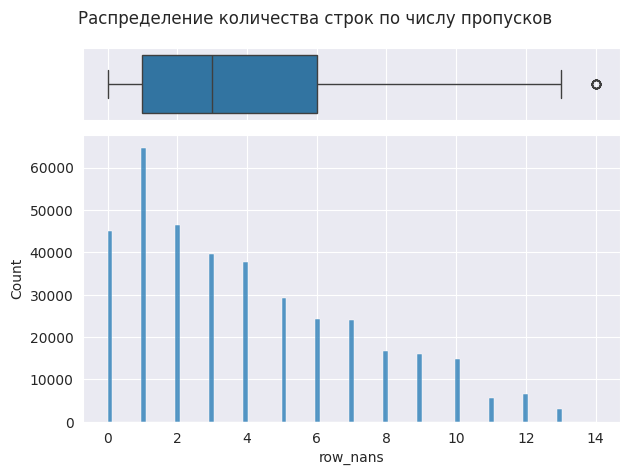

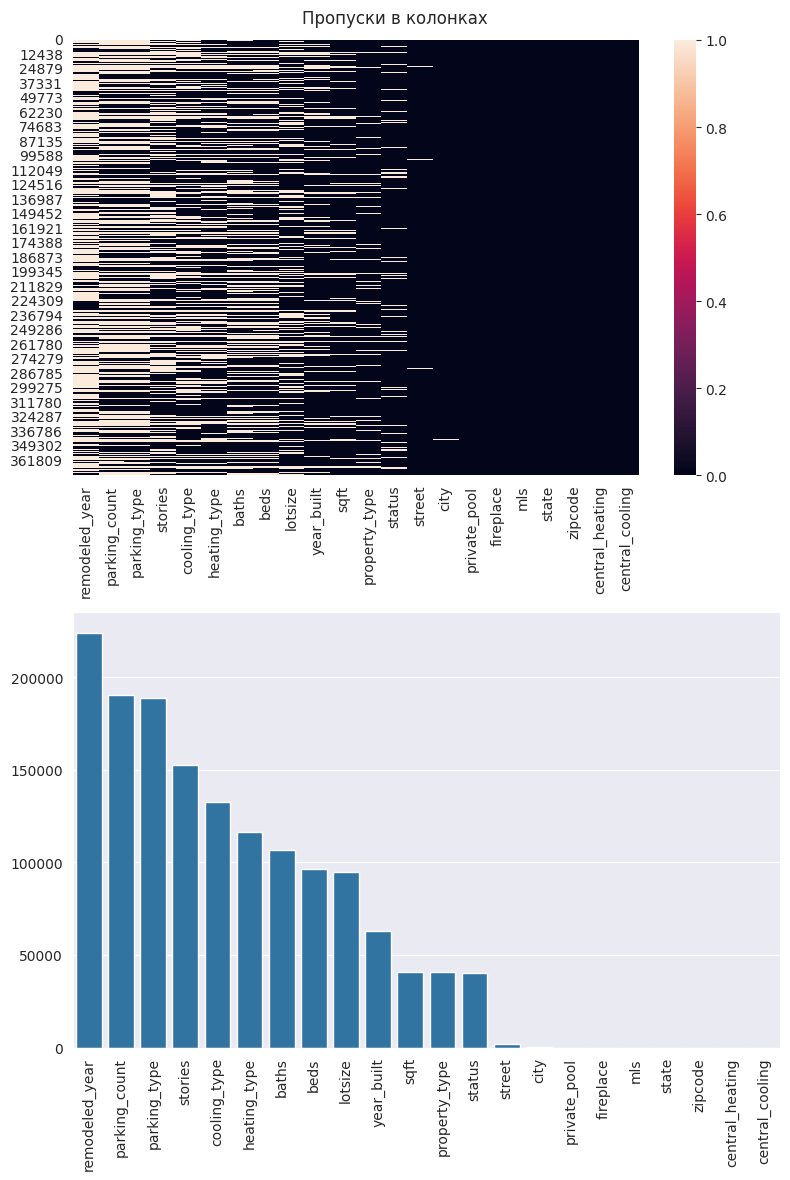

In [5]:
check_nans = [
    *advert_cols,
    *address_cols,
    *home_property_cols,
]

row_nans = df[check_nans].isna().sum(axis=1)
ten_more_nans = row_nans.value_counts()[10:].sum()
ten_more_nans_percentage = utils.get_percentage(ten_more_nans, df.shape[0])
print(f'Доля строк с 10 пропусками и более: {ten_more_nans_percentage}')


visualize.plot_nans_stat(df, check_nans=check_nans);

- `remodeled_year` - больше всего пропусков. Будем объединять с `year_built` по типу `last_remodeled_year`
- `parking_count`, `parking_type` - больше 50% пропусков, появившихся из-за пустых строк в этих признаках.
Можно ввести явную категорию отсутствия данных "no" в parking_type. parking_count требует более детального анализа.
- `stories`

Сохраняем строки содержащие меньше 10 пропусков:

In [6]:
df = df[row_nans < 10]
print(f'Размер датасета: {df.shape}')

Размер датасета: (343140, 27)


# Анализ и подготовка признаков

## Target

Рассмотрим выбросы в target более подробно

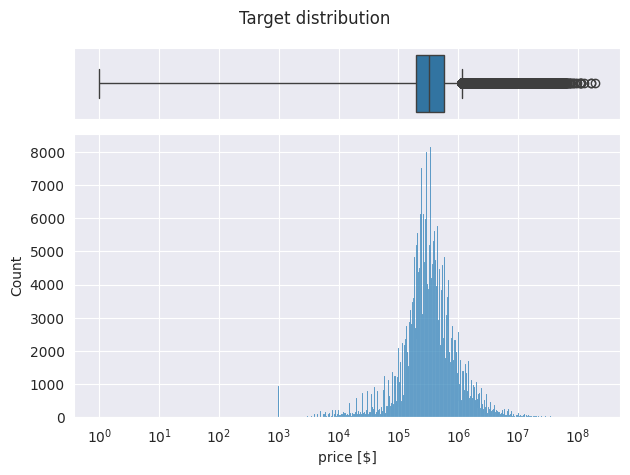

In [7]:
visualize.plot_box_hist_plot(
    df, 
    'target', 
    numeric_label='price [$]', 
    log_scale=True, 
    title='Target distribution',
);

### price <= 1000 $

Сперва оценим значения меньше тыс. долларов

In [8]:
df[df['target']< 1e3].describe()

,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count
count,18.000000,33.000000,30.000000,8.000000,44.000000,34.000000,11.000000,4.000000e+01,14.000000
mean,2.166667,4153.363636,4.133333,1.750000,418.909091,1915.558824,1965.818182,7.706934e+05,1.214286
std,0.542326,12666.236618,1.575312,0.707107,300.726084,40.475351,32.495594,2.572072e+06,0.801784
min,1.000000,0.000000,1.500000,1.000000,1.000000,1865.000000,1889.000000,8.400000e+02,1.000000
25%,2.000000,1064.000000,3.000000,1.000000,1.000000,1881.250000,1957.000000,2.312500e+03,1.000000
50%,2.000000,1656.000000,4.000000,2.000000,600.000000,1900.000000,1975.000000,3.645000e+03,1.000000
75%,2.375000,2288.000000,6.000000,2.000000,600.000000,1940.750000,1989.000000,2.352240e+04,1.000000
max,3.000000,73260.000000,7.000000,3.000000,825.000000,2005.000000,1996.000000,1.171764e+07,4.000000


Видим, что всего 77 строк имеют такую цену, причём больше половины имеют пропуски.
Смело будем удалять их.

Есть большое количество квартир с указанием цены в 1 тыс. долларов

In [9]:
display(df[df['target'] == 1e3].describe())

columns_list = [
    'status', 'property_type', 'state', 'city', 'fireplace',
]

for column in columns_list:
    display(df[df['target'] == 1e3][column].value_counts())

,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count
count,304.000000,921.000000,881.000000,691.000000,937.0,920.000000,0.0,937.000000,623.000000
mean,1.999671,1265.180239,3.246311,1.377713,1000.0,1931.296739,NaN,4394.739168,1.027287
std,0.395895,529.946911,0.981390,0.485167,0.0,12.759685,NaN,2084.753232,0.198613
min,1.000000,0.000000,0.000000,1.000000,1000.0,1886.000000,NaN,1742.000000,1.000000
25%,2.000000,874.000000,3.000000,1.000000,1000.0,1923.000000,NaN,3485.000000,1.000000
50%,2.000000,1148.000000,3.000000,1.000000,1000.0,1926.000000,NaN,3920.000000,1.000000
75%,2.000000,1470.000000,4.000000,2.000000,1000.0,1942.000000,NaN,4792.000000,1.000000
max,4.000000,3324.000000,7.000000,2.000000,1000.0,1971.000000,NaN,44866.800000,4.000000


status
foreclosure    874
sale            20
active           2
Name: count, dtype: int64

property_type
single    910
land       27
Name: count, dtype: int64

state
MI    910
TN     19
NY      7
NC      1
Name: count, dtype: int64

city
Detroit          900
Memphis           18
Highland Park      8
Albany             7
Battle Creek       2
Jacksonville       1
Arlington          1
Name: count, dtype: int64

fireplace
False    732
True     205
Name: count, dtype: int64

Видим, что большая часть объявлений это аукцион по случаю банкротства в городе-призраке Детройт. Причём речь идёт о домах, а не об участках

Возможно, имеет смысл исключить эти объявления

### 1 000 \$ < price < 10 000 \$

In [10]:
price_mask = df['target'].between(1e3, 1e4, inclusive='neither')
display(df[price_mask].describe())

columns_list = [
    'status', 'property_type', 'state', 'city'
]

for column in columns_list:
    display(df[price_mask][column].value_counts())

,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count
count,1109.000000,1930.000000,387.000000,256.000000,2586.000000,454.000000,114.000000,2.452000e+03,217.000000
mean,0.313796,401.270984,3.803618,1.584766,6702.399459,1933.006608,1958.473684,1.301509e+04,5.741935
std,0.710401,1326.811396,7.655461,0.720704,2134.070312,33.672654,27.720862,4.516156e+04,60.545803
min,0.000000,0.000000,0.000000,0.000000,1100.000000,1860.000000,1895.000000,1.800000e+02,0.000000
25%,0.000000,0.000000,2.000000,1.000000,5000.000000,1910.000000,1944.500000,8.125000e+03,1.000000
50%,0.000000,0.000000,3.000000,2.000000,6900.000000,1926.000000,1959.000000,1.000000e+04,1.000000
75%,0.000000,0.000000,3.000000,2.000000,8500.000000,1952.750000,1974.750000,1.129125e+04,1.000000
max,5.000000,34848.000000,64.000000,6.000000,9999.000000,2019.000000,2009.000000,1.742400e+06,888.000000


status
active         1367
sale            926
pending         154
foreclosure      51
contingency       2
auction           1
new               1
Name: count, dtype: int64

property_type
land        2213
single       210
multi         54
apt           28
mobile        26
condo         19
town          10
colonial       2
ranch          2
cape           1
Name: count, dtype: int64

state
FL    1977
NY      92
OH      91
MI      77
IL      60
TN      52
WA      46
NC      44
TX      39
IN      30
WI      20
PA      18
MO      12
GA      10
CA       5
OK       4
VA       3
CO       1
DC       1
MA       1
OR       1
IA       1
KY       1
Name: count, dtype: int64

city
Port Charlotte    576
Lehigh Acres      493
Ocala             244
Punta Gorda       212
Rotonda West       64
                 ... 
West Hollywood      1
Herkimer            1
Washington          1
Marshall            1
Dallas              1
Name: count, Length: 161, dtype: int64

In [11]:
display(df[df['property_type'] == 'apt'].describe())

,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count
count,258.000000,665.000000,282.000000,181.000000,6.940000e+02,661.000000,86.000000,1.410000e+02,169.000000
mean,2.802326,13279.374436,2.946809,6.099448,1.041458e+06,1973.674735,1934.011628,5.647237e+04,4.704142
std,1.652046,60602.657191,2.578450,7.822407,1.775255e+06,38.466929,301.123602,1.966291e+05,40.608996
min,1.000000,22.000000,0.000000,1.000000,1.200000e+03,1830.000000,0.000000,1.370000e+02,1.000000
25%,2.000000,850.000000,2.000000,1.000000,3.490000e+05,1949.000000,1970.250000,3.920000e+03,1.000000
50%,2.000000,1181.000000,2.000000,2.000000,5.990000e+05,1981.000000,1981.500000,9.239000e+03,1.000000
75%,3.000000,2208.000000,3.000000,7.000000,9.415000e+05,2007.000000,1999.000000,2.221560e+04,2.000000
max,13.000000,605018.000000,27.000000,42.000000,1.755000e+07,2019.000000,2018.000000,2.003760e+06,529.000000


Большая часть объявлений с такой ценой - голые земельные участки.

Однако встречаются и отдельные дома, также как и апартаменты.
Последние имеет смысл исключить в дальнейшем, так как их нельзя покупать, а только брать в аренду.

На текущий момент имеет смысл исключить из рассмотрения объявления дешевле 10_000$

### price > $10^7$ \$

In [12]:
price_mask = df['target']>1e7
display(df[price_mask].describe())

columns_list = [
    'status', 'property_type', 'state', 'city'
]

for column in columns_list:
    display(df[price_mask][column].value_counts())

,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count
count,1108.000000,1193.000000,1121.000000,654.000000,1.271000e+03,1190.000000,521.000000,8.030000e+02,611.000000
mean,8.590253,11616.595138,6.702498,9.513761,2.055996e+07,1977.433613,1990.088292,3.989219e+05,18.770867
std,22.963697,29237.147257,23.169174,18.593536,1.493824e+07,43.651154,27.244899,2.875306e+06,113.376725
min,0.000000,0.000000,0.000000,1.000000,1.015000e+07,1800.000000,1738.000000,1.000000e+00,0.000000
25%,5.000000,5146.000000,4.000000,2.000000,1.250000e+07,1934.250000,1979.000000,1.050000e+04,1.000000
50%,7.000000,7746.000000,5.000000,3.000000,1.552132e+07,2000.000000,1999.000000,2.395800e+04,1.000000
75%,9.000000,11204.000000,7.000000,5.000000,2.290000e+07,2015.000000,2008.000000,4.965840e+04,3.000000
max,750.000000,600613.000000,750.000000,96.000000,1.950000e+08,2021.000000,2019.000000,4.835160e+07,888.000000


status
sale           939
active         179
new             17
pending          4
foreclosure      1
Name: count, dtype: int64

property_type
single         579
condo          429
town            90
multi           52
land            44
apt              6
spanish          5
modern           2
traditional      2
europe           2
ranch            2
Name: count, dtype: int64

state
FL    414
NY    405
CA    281
TX     64
MA     28
WA     18
NV     15
DC     13
TN     10
IL      8
GA      4
PA      4
CO      3
UT      1
OH      1
VT      1
VA      1
Name: count, dtype: int64

city
New York              388
Miami Beach           148
Los Angeles           129
Miami                  54
Fort Lauderdale        54
                     ... 
Fresno                  1
Pataskala               1
Boca Grande             1
CHERRYHILLSVILLAGE      1
East Palo Alto          1
Name: count, Length: 109, dtype: int64

Оставляем для начала цены в диапазоне $10^4\$ - 10^7\$$

Размер датасета: (338302, 27)


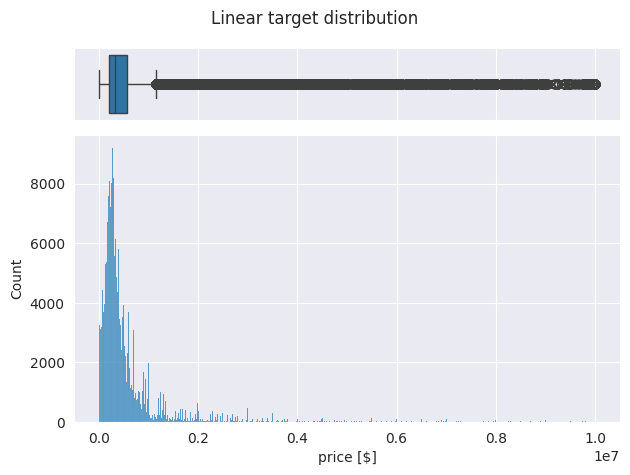

In [13]:
df = df[df['target'].between(1e4, 1e7)]
print(f'Размер датасета: {df.shape}')

visualize.plot_box_hist_plot(
    df, 
    'target', 
    numeric_label='price [$]', 
    log_scale=False, 
    title='Linear target distribution',
);

Введём логарифмированный таргет и проверим его на нормальность

p = 0.000e+00
Данные не распределены нормально (мы отвергаем H0)
Количество выбросов в log_target по методу Тьюки: 17194
Количество выбросов в log_target по методу z-отклонений: 3994


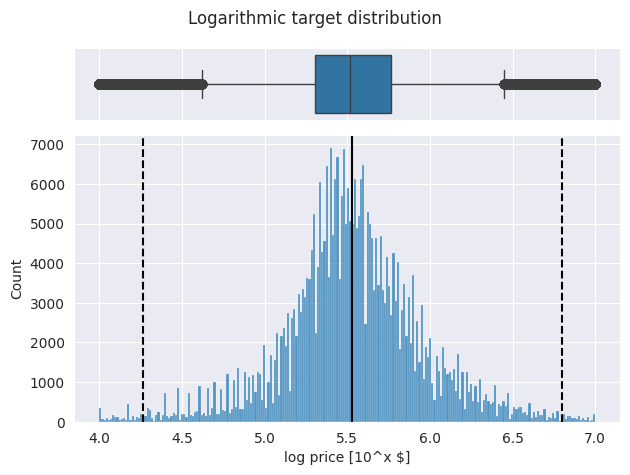

In [14]:
df['log_target'] = np.log10(df['target'])

visualize.plot_box_hist_plot(
    df, 
    'log_target', 
    numeric_label='log price [10^x $]', 
    log_scale=False, 
    title='Logarithmic target distribution',
    std_lines=True
);

p = feature_stats.test_normal(df['log_target'])

clean_iqr, outliers_iqr, _ = feature_stats.get_outliers_iqr(df, 'log_target')
clean_z, outliers_z, _ = feature_stats.get_outliers_z_score(df, 'log_target')

Хоть распределение не является нормальным, воспользуемся методом z-отклонений, чтобы сильно не урезать датасет

ITERATION 1
Количество выбросов в log_target по методу z-отклонений: 3994
ITERATION 2
Количество выбросов в log_target по методу z-отклонений: 1917
ITERATION 3
Количество выбросов в log_target по методу z-отклонений: 611
ITERATION 4
Количество выбросов в log_target по методу z-отклонений: 245
ITERATION 5
Количество выбросов в log_target по методу z-отклонений: 34
ITERATION 6
Количество выбросов в log_target по методу z-отклонений: 55
ITERATION 7
Количество выбросов в log_target по методу z-отклонений: 2
ITERATION 8
Количество выбросов в log_target по методу z-отклонений: 0


DATAFRAME: outliers


,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count,log_target
count,4093.000000,6130.000000,3524.000000,2475.000000,6.858000e+03,4087.000000,1695.000000,5.716000e+03,2140.000000,6858.000000
mean,4.048375,3985.460196,4.730562,3.345859,2.824582e+06,1965.749939,1971.171681,4.969669e+05,15.705140,5.290948
std,12.263252,15937.079812,13.405782,7.179991,3.471752e+06,42.674830,148.361442,2.528620e+07,109.331491,1.292787
min,0.000000,0.000000,0.000000,0.000000,1.000000e+04,1750.000000,0.000000,1.000000e+00,0.000000,4.000000
25%,0.000000,0.000000,3.000000,1.000000,1.500000e+04,1927.000000,1962.000000,6.520000e+03,1.000000,4.176091
50%,4.000000,1462.500000,4.000000,2.000000,2.190000e+04,1968.000000,1989.000000,1.085800e+04,1.000000,4.340444
75%,6.000000,5150.000000,5.000000,3.000000,5.995000e+06,2008.000000,2007.000000,2.178000e+04,1.000000,6.777789
max,750.000000,705000.000000,750.000000,91.000000,1.000000e+07,2022.000000,2019.000000,1.859533e+09,888.000000,7.000000


status
sale               3364
active             2689
pending             176
foreclosure         117
new                  61
under_contract       23
pre-foreclosure      23
contingency          15
auction              13
backup                1
Name: count, dtype: int64

property_type
land            2938
single          2093
condo            778
multi            331
mobile           207
town             139
ranch             32
traditional       30
colonial          27
modern            17
apt               17
spanish           14
cape              10
europe             7
florida            2
transitional       1
Name: count, dtype: int64

state
FL    3083
NY     649
CA     593
TX     497
OH     384
MI     286
TN     246
NC     230
IL     159
PA     137
GA     126
WA     112
IN      99
MA      58
DC      57
NV      38
CO      23
VA      14
MO      14
ME      14
OR      10
WI       8
UT       7
VT       4
MD       3
AZ       2
OK       2
KY       2
IA       1
Name: count, dtype: int64

city
New York                 431
Port Charlotte           337
Cleveland                302
Ocala                    297
Punta Gorda              251
                        ... 
Fremont                    1
Saint Johns                1
Silver Springs Shores      1
Oklawaha                   1
Hunters Creek Village      1
Name: count, Length: 420, dtype: int64

DATAFRAME: clean


,baths,sqft,beds,stories,target,year_built,remodeled_year,lotsize,parking_count,log_target
count,259171.000000,3.209920e+05,269933.000000,216374.000000,3.314440e+05,301629.000000,145899.000000,2.508860e+05,178958.000000,331444.000000
mean,3.370437,6.749454e+03,3.886109,1.956600,5.126256e+05,1979.846076,1979.781753,1.169127e+05,2.542306,5.535854
std,22.533711,1.619890e+06,21.409293,4.094138,5.802138e+05,33.231649,82.757123,8.780671e+06,33.340199,0.381829
min,0.000000,0.000000e+00,0.000000,0.000000,2.465000e+04,1700.000000,0.000000,1.000000e+00,0.000000,4.391817
25%,2.000000,1.259000e+03,3.000000,1.000000,2.085000e+05,1957.000000,1968.000000,5.001000e+03,1.000000,5.319106
50%,2.500000,1.803000e+03,3.000000,2.000000,3.300000e+05,1985.000000,1986.000000,7.840000e+03,1.000000,5.518514
75%,3.000000,2.570000e+03,4.000000,2.000000,5.750000e+05,2007.000000,2004.000000,1.306800e+04,2.000000,5.759668
max,750.000000,7.959794e+08,750.000000,1120.000000,4.800000e+06,2022.000000,2021.000000,2.147484e+09,5209.000000,6.681241


status
sale               181521
active              86378
pending              6357
new                  6013
foreclosure          5127
under_contract       3383
pre-foreclosure      3241
auction              1305
contingency          1084
backup                384
Name: count, dtype: int64

property_type
single          186135
condo            45194
town             26631
land             14406
multi            13505
traditional       7029
ranch             4219
modern            3629
mobile            3285
colonial          1228
apt                643
spanish            626
florida            606
transitional       583
cape               309
log                289
europe             283
Name: count, dtype: int64

state
FL    99244
TX    76228
CA    21593
NC    19182
NY    17266
TN    15503
WA    12777
OH    11465
IL     8299
NV     7872
GA     6295
CO     6183
PA     5062
DC     4372
MI     3737
AZ     3262
IN     3026
OR     2714
MA     1392
UT     1217
MD     1077
MO      805
VT      788
VA      762
WI      374
NJ      326
IA      238
ME      186
KY       87
OK       43
MS       28
SC       28
MT        6
DE        5
Fl        1
AL        1
Name: count, dtype: int64

city
Houston           22226
San Antonio       14524
Miami             14514
Jacksonville       9053
Dallas             8042
                  ...  
Shasta                1
Sheepshead Bay        1
Gulf Hammock          1
Leona valley          1
Blue Springs          1
Name: count, Length: 1918, dtype: int64

Размер датасета: (331444, 28)


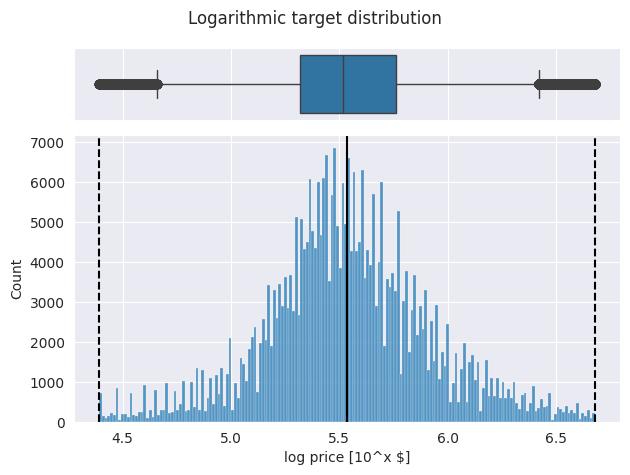

In [15]:
clean, outliers = feature_stats.get_df_no_outliers(
    data=df,
    feature='log_target',
    method='z-score'
)
print()
print()

# Сравним свойства
for name, sub_df in [('outliers', outliers), ('clean', clean)]:
    print(f'DATAFRAME: {name}')
    display(sub_df.describe())

    columns_list = [
        'status', 'property_type', 'state', 'city'
    ]

    for column in columns_list:
        display(sub_df[column].value_counts())

df = clean
print(f'Размер датасета: {df.shape}')

visualize.plot_box_hist_plot(
    df, 
    'log_target', 
    numeric_label='log price [10^x $]', 
    log_scale=False, 
    title='Logarithmic target distribution',
    std_lines=True
);

Больше всего "отлетело" земельных участков и отдельных домов.
Но в целом, пропорция по рассмотренным признакам сохраняется.

Выбросы по IQR пока удалять не будем.
При необходимости, их можно будет чистить перед этапом обучения.

## Status

In [16]:
df['status'].value_counts()

status
sale               181521
active              86378
pending              6357
new                  6013
foreclosure          5127
under_contract       3383
pre-foreclosure      3241
auction              1305
contingency          1084
backup                384
Name: count, dtype: int64

status


status
sale               0.615757
active             0.293012
pending            0.021564
new                0.020397
foreclosure        0.017392
under_contract     0.011476
pre-foreclosure    0.010994
auction            0.004427
contingency        0.003677
backup             0.001303
Name: proportion, dtype: float64

Доля объявлений с пропуском в status: 11.058%


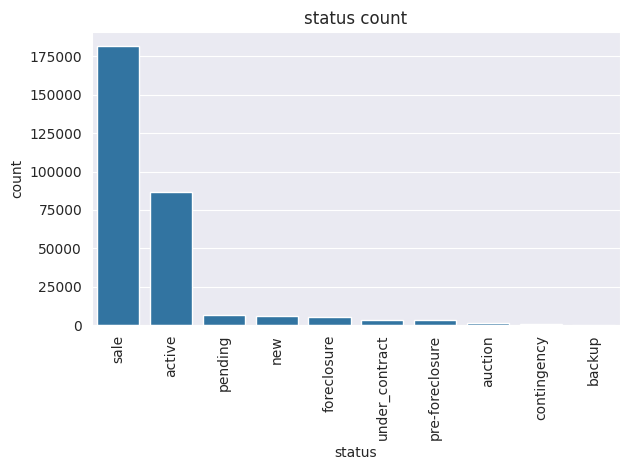

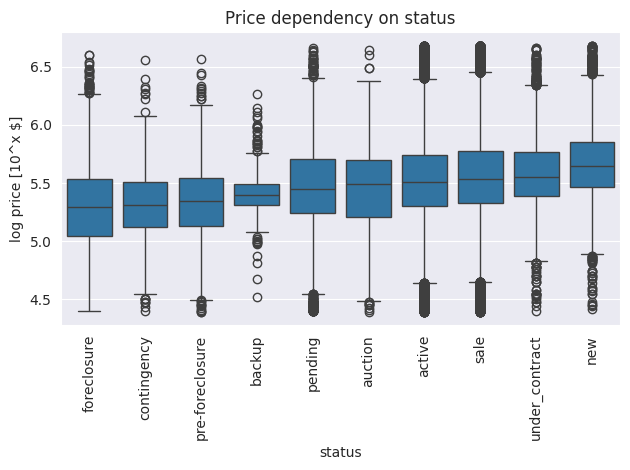

In [17]:
visualize.plot_categorical_stats(
    df,
    target='log_target',
    numeric_label='log price [10^x $]',
    feature_names=('status',),
)

status


status
active/sale            0.922795
foreclosure/pending    0.048856
contract/new           0.028349
Name: proportion, dtype: float64

Доля объявлений с пропуском в status: 0.000%


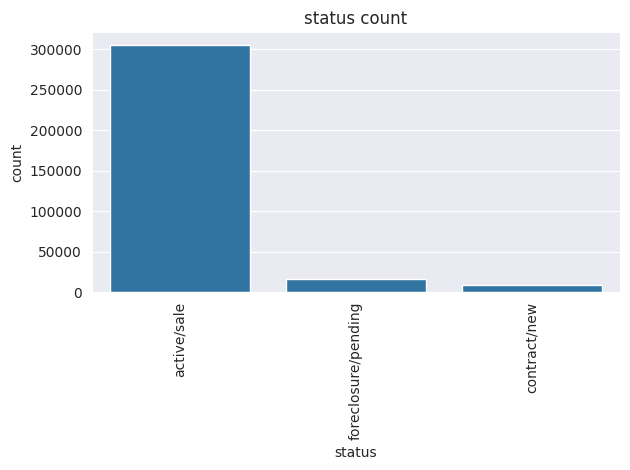

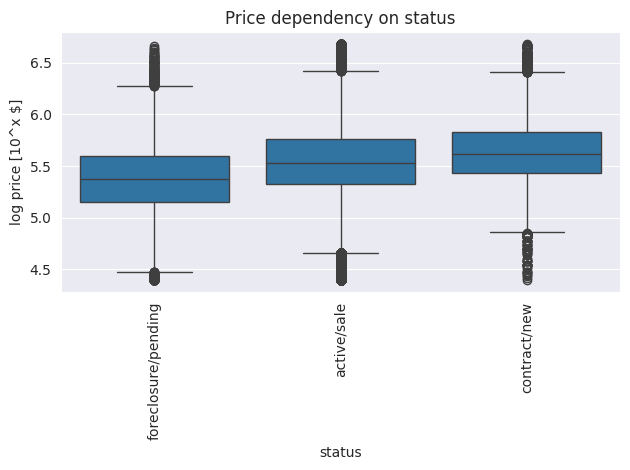

In [18]:
isin_dict = {
    'contract/new': ['new', 'under_contract'],
    'active/sale': ['active', 'auction', 'sale'],
    'foreclosure/pending': [
        'foreclosure', 'pre-foreclosure', 'pending', 'backup', 'contingency'
    ],
}

df['status'] = build_features.get_categorical_feature(
    df['status'],
    isin_dict=isin_dict
)
df['status'] = df['status'].fillna(df['status'].mode().iloc[0])

visualize.plot_categorical_stats(
    df,
    target='log_target',
    numeric_label='log price [10^x $]',
    feature_names=('status',),
)

## street, city, state, zipcode

Города, Улицы и zipcode можно удалять (см 1.0-mv-data-understanding.ipynb). 
Они могут быть полезны только в случае расширения признаков, характерных для района, города.

Размер датасета: (331444, 25)
state


state
FL    0.299429
TX    0.229988
CA    0.065148
NC    0.057874
NY    0.052093
TN    0.046774
WA    0.038549
OH    0.034591
IL    0.025039
NV    0.023751
GA    0.018993
CO    0.018655
PA    0.015273
DC    0.013191
MI    0.011275
AZ    0.009842
IN    0.009130
OR    0.008188
MA    0.004200
UT    0.003672
MD    0.003249
MO    0.002429
VT    0.002377
VA    0.002299
WI    0.001128
NJ    0.000984
IA    0.000718
ME    0.000561
KY    0.000262
OK    0.000130
MS    0.000084
SC    0.000084
MT    0.000018
DE    0.000015
Fl    0.000003
AL    0.000003
Name: proportion, dtype: float64

Доля объявлений с пропуском в state: 0.000%


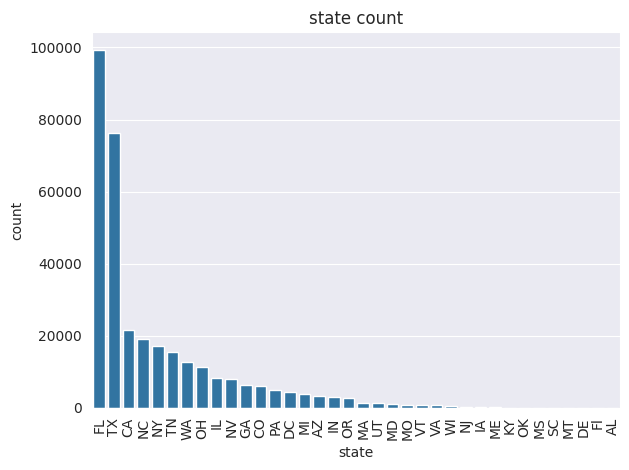

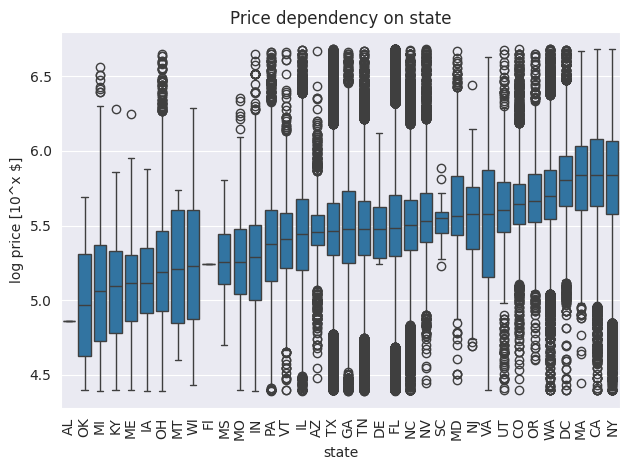

In [19]:
df = df.drop(['street', 'zipcode', 'city'], axis=1)
print(f'Размер датасета: {df.shape}')

visualize.plot_categorical_stats(
    df,
    target='log_target',
    numeric_label='log price [10^x $]',
    feature_names=('state',),
)

Возьмём топовые по количеству объявлений штаты, остальные заполним как "other"

state


state
FL       0.299429
TX       0.229988
other    0.175553
CA       0.065148
NC       0.057874
NY       0.052093
TN       0.046774
WA       0.038549
OH       0.034591
Name: proportion, dtype: float64

Доля объявлений с пропуском в state: 0.000%


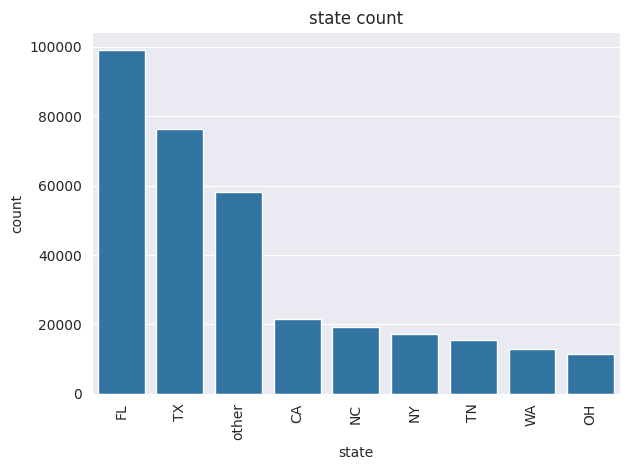

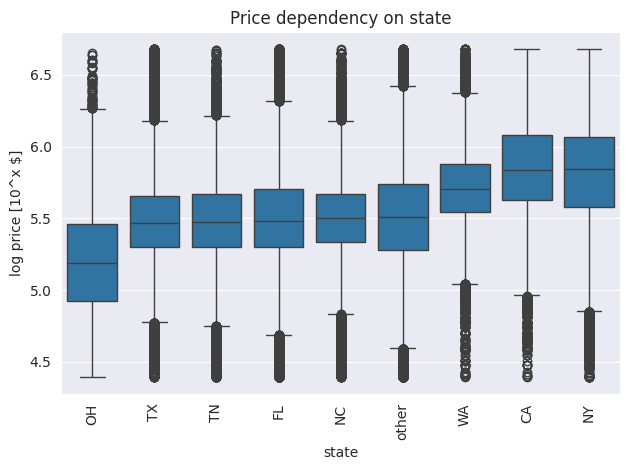

In [20]:
states_count = df['state'].value_counts(normalize=True)
states_count.iloc[:8]

other_states = states_count.iloc[8:].index
other_states

df['state'] = build_features.get_categorical_feature(
    df['state'],
    isin_dict={
        "other": other_states,
    },
    first_launch=False,
    lower_strip=False,
)

visualize.plot_categorical_stats(
    df,
    target='log_target',
    numeric_label='log price [10^x $]',
    feature_names=('state',),
)

## Property type

property_type


property_type
single          0.603159
condo           0.146448
town            0.086296
land            0.046682
multi           0.043762
traditional     0.022777
ranch           0.013671
modern          0.011760
mobile          0.010645
colonial        0.003979
apt             0.002084
spanish         0.002029
florida         0.001964
transitional    0.001889
cape            0.001001
log             0.000936
europe          0.000917
Name: proportion, dtype: float64

Доля объявлений с пропуском в property_type: 6.892%


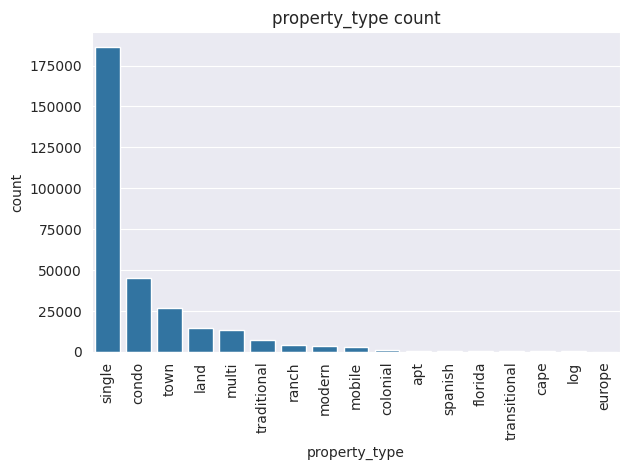

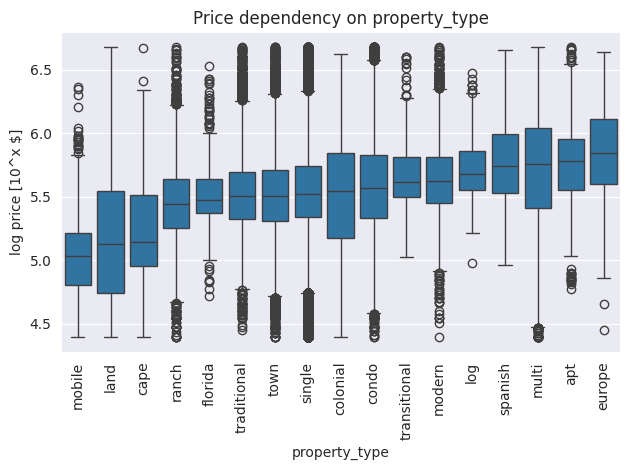

In [21]:
visualize.plot_categorical_stats(
    df,
    target='log_target',
    numeric_label='log price [10^x $]',
    feature_names=('property_type',),
)

- Удаляем строки с "apt" - они не для продажи
- "cape" -> np.nan
- Группируем: "log", "spanish", "europe", "modern", "transitional" -> "styled"
- Группируем: "colonial", "condo" -> "condo"
- Группируем: "traditional", "florida" -> "traditional"
- Заполняем NaNs как "single"
- "mobile", "land" -> "land/mobile"

Размер датасета: (330801, 25)
property_type


property_type
single               0.632670
condo                0.140332
town                 0.080505
land/mobile          0.053479
multi                0.040825
ranch/traditional    0.035834
styled               0.016354
Name: proportion, dtype: float64

Доля объявлений с пропуском в property_type: 0.000%


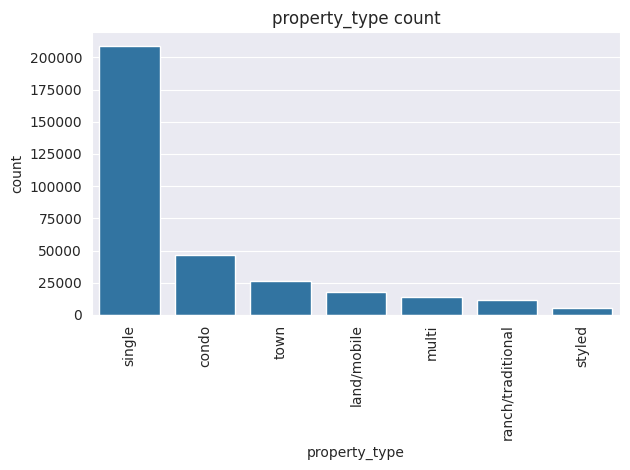

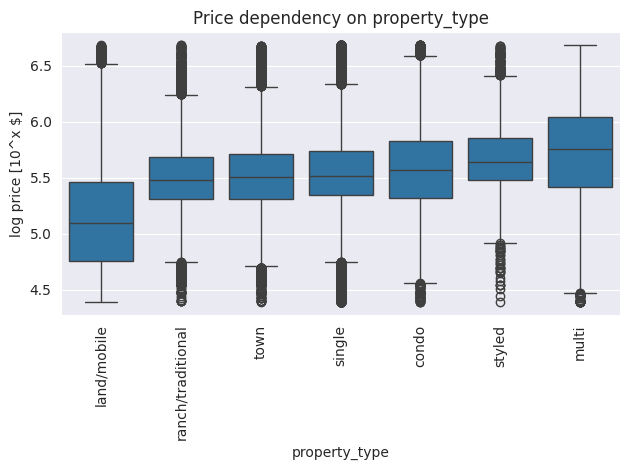

In [22]:
df = df[df['property_type'] != 'apt']
print(f'Размер датасета: {df.shape}')
df.loc[df['property_type'] == 'cape', 'property_type'] = np.nan

# Fill in advance land properties as zero:
df.loc[df['property_type'] == 'land', ['stories', 'beds', 'baths']] = 0

df['property_type'] = build_features.get_categorical_feature(
    df['property_type'],
    isin_dict={
        "styled": ["log", "spanish", "europe", "modern", "transitional"],
        "condo": ["colonial", "condo"],
        "ranch/traditional": ["ranch", "traditional", "florida"],
        "land/mobile": ["mobile", "land"]
    },
    first_launch=False,
    lower_strip=False,
)
df['property_type'] = df['property_type'].fillna(
    df['property_type'].mode().iloc[0]
)

visualize.plot_categorical_stats(
    df,
    target='log_target',
    numeric_label='log price [10^x $]',
    feature_names=('property_type',),
)

## baths, beds, stories

Удалим явные выбросы для удобства последующего анализа.

Затем избавимся от дробных значений целочисленным округлением (дробные категории малочисленны)

Анализировать будем как категориальные (ordinal) признаки.

Заполним также пропуски в соответствии с property_type

Размер датасета: (330799, 25)
stories


stories
1.0     0.443015
2.0     0.372146
3.0     0.076165
0.0     0.063063
9.0     0.014564
          ...   
75.0    0.000009
78.0    0.000009
62.0    0.000004
82.0    0.000004
51.0    0.000004
Name: proportion, Length: 68, dtype: float64

Доля объявлений с пропуском в stories: 30.944%


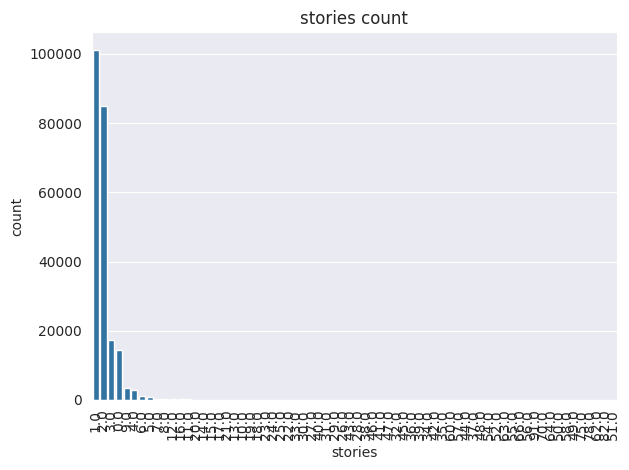

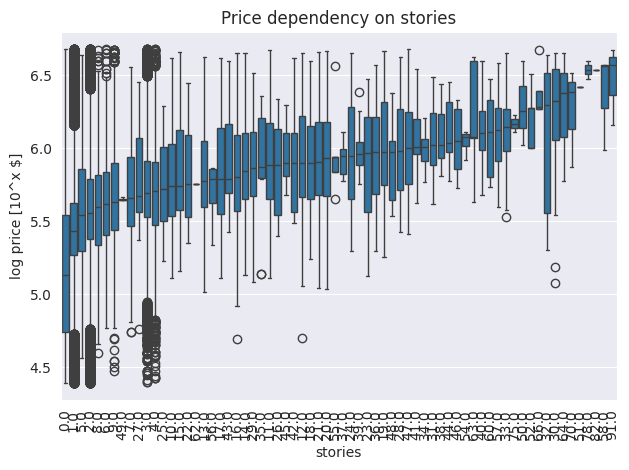

beds


beds
3.0     0.371080
4.0     0.240046
2.0     0.197396
5.0     0.073324
0.0     0.055256
1.0     0.029324
6.0     0.020402
7.0     0.005196
8.0     0.003804
9.0     0.001474
10.0    0.000888
12.0    0.000622
11.0    0.000391
16.0    0.000224
13.0    0.000139
14.0    0.000135
15.0    0.000110
18.0    0.000099
20.0    0.000043
17.0    0.000032
19.0    0.000018
Name: proportion, dtype: float64

Доля объявлений с пропуском в beds: 14.889%


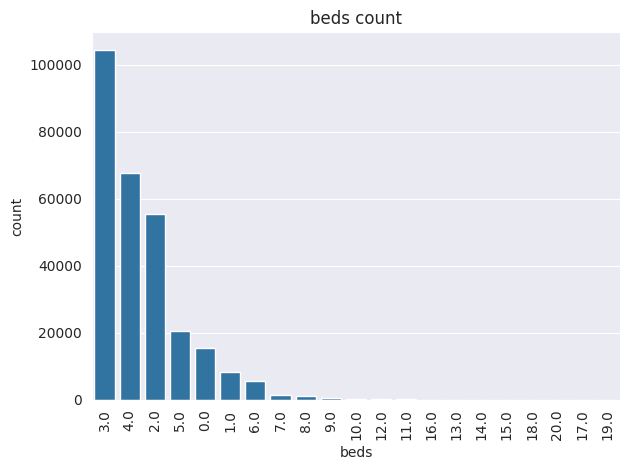

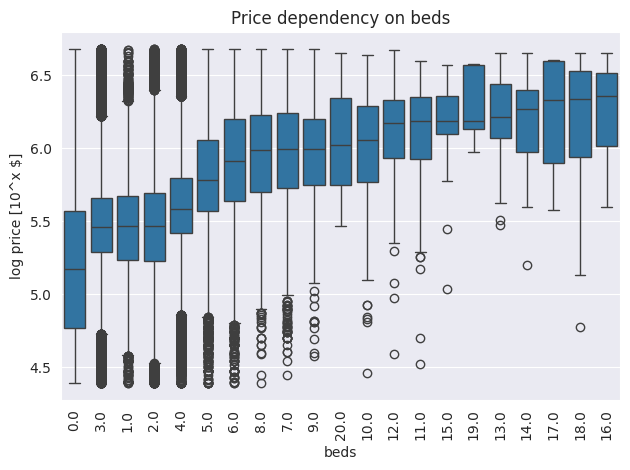

baths


baths
2.0     0.450160
3.0     0.245657
4.0     0.122145
1.0     0.067189
0.0     0.053844
5.0     0.032502
6.0     0.016336
7.0     0.006030
8.0     0.003283
9.0     0.001027
10.0    0.000628
11.0    0.000314
12.0    0.000299
16.0    0.000159
13.0    0.000137
18.0    0.000092
14.0    0.000078
15.0    0.000055
20.0    0.000044
17.0    0.000015
19.0    0.000007
Name: proportion, dtype: float64

Доля объявлений с пропуском в baths: 18.132%


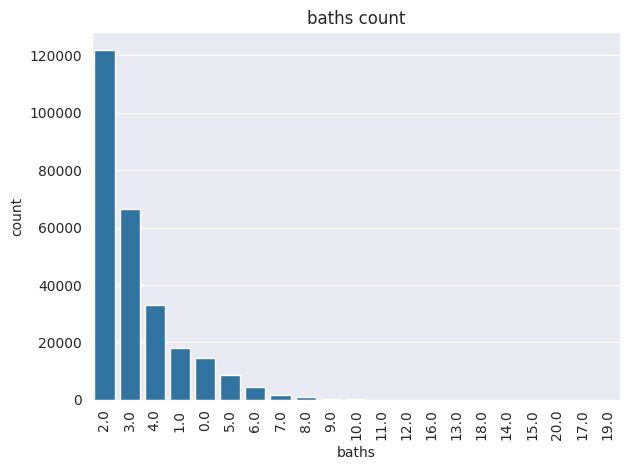

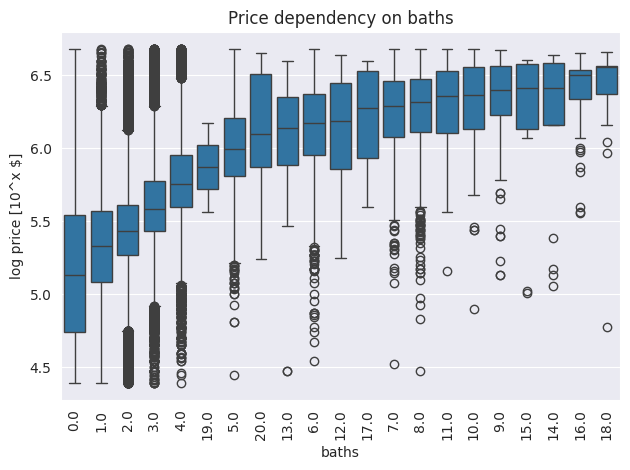

In [23]:
for feature in ('beds', 'baths'):
    df.loc[df[feature]>20, feature] = np.nan
df = df[~(df['stories'] > 100)]
print(f'Размер датасета: {df.shape}')

for feature in ('stories', 'beds', 'baths'):
    df[feature] = np.round(df[feature])

visualize.plot_categorical_stats(
    df,
    feature_names=('stories', 'beds', 'baths'),
    target='log_target',
    numeric_label='log price [10^x $]',
    
)

Группируем:
- stories: 4+ -> 4
- baths: 6+ -> 6
- beds: 7+ -> 7

stories


stories
1.0    0.560537
2.0    0.306679
3.0    0.052597
0.0    0.048691
4.0    0.031496
Name: proportion, dtype: float64

Доля объявлений с пропуском в stories: 0.000%


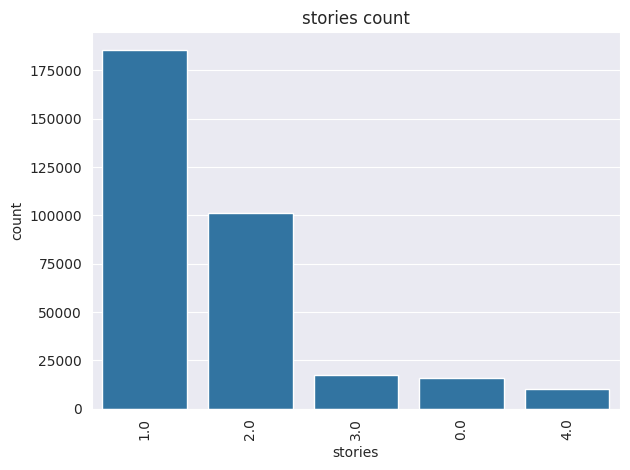

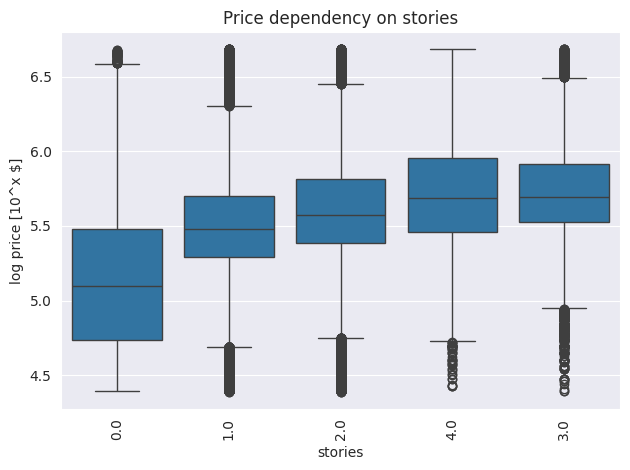

beds


beds
3.0    0.386845
2.0    0.235031
4.0    0.214650
5.0    0.062406
0.0    0.047533
1.0    0.024958
6.0    0.017364
7.0    0.011212
Name: proportion, dtype: float64

Доля объявлений с пропуском в beds: 0.000%


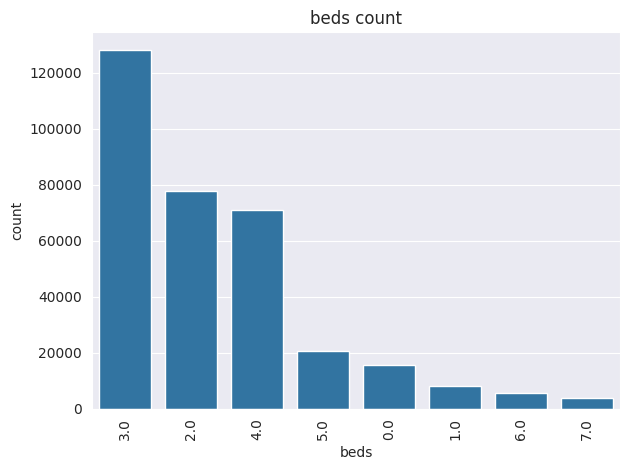

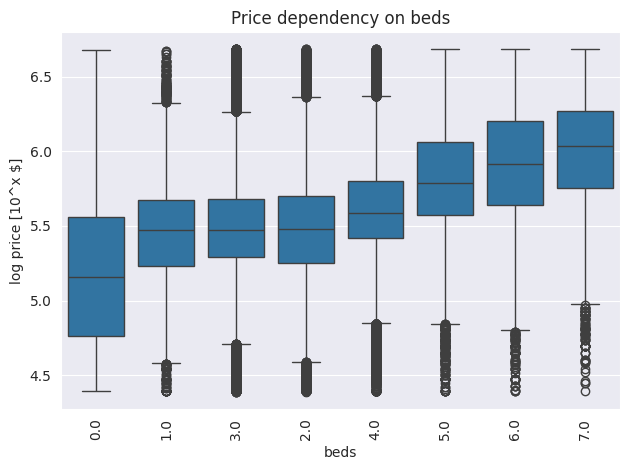

baths


baths
2.0    0.548986
3.0    0.201113
4.0    0.099997
1.0    0.055006
0.0    0.044955
5.0    0.026608
6.0    0.023334
Name: proportion, dtype: float64

Доля объявлений с пропуском в baths: 0.000%


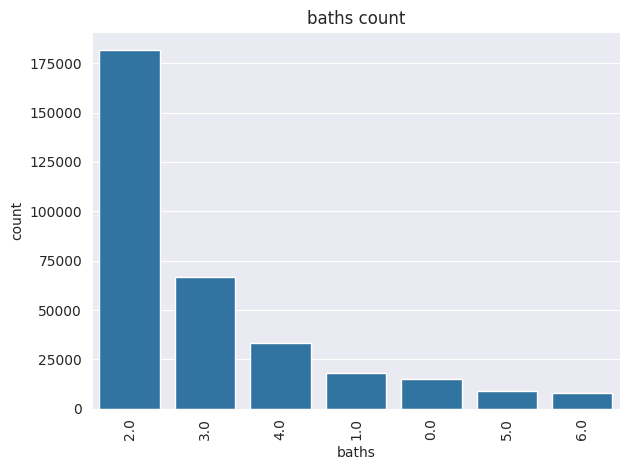

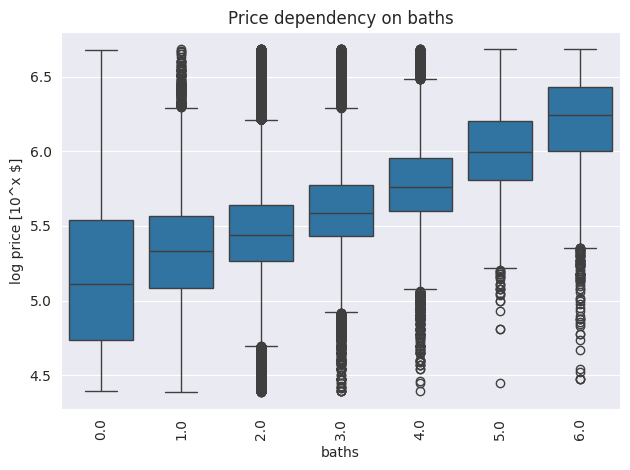

In [24]:
# FILL NANS according to property_type
features = ('stories', 'beds', 'baths')
reference = 'property_type'
df = feature_stats.fillna_by_reference(
    df,
    reference=reference,
    features=features
)

# CROP ACCORDING TO THRESHOLD
feature_thresholds = {
    'stories': (0, 4),
    'baths': (0, 6),
    'beds': (0, 7)
}
df = feature_stats.clip_by_thresholds(
    df, 
    feature_thresholds=feature_thresholds
)

visualize.plot_categorical_stats(
    df,
    feature_names=('stories', 'beds', 'baths'),
    target='log_target',
    numeric_label='log price [10^x $]',   
)

## sqft and lotsize

Логарифмируем предварительно площади участков

log_sqft
p = 0.000e+00
Данные не распределены нормально (мы отвергаем H0)

log_lotsize
p = 0.000e+00
Данные не распределены нормально (мы отвергаем H0)

log_sqft


count    320364.000000
mean          3.192890
std           0.569688
min           0.000000
25%           3.100715
50%           3.256477
75%           3.410102
max           8.900902
Name: log_sqft, dtype: float64

Доля объявлений с пропуском в log_sqft: 3.154%


log_lotsize


count    250745.000000
mean          3.919811
std           0.633281
min           0.301030
25%           3.699144
50%           3.894371
75%           4.116242
max           9.331930
Name: log_lotsize, dtype: float64

Доля объявлений с пропуском в log_lotsize: 24.200%


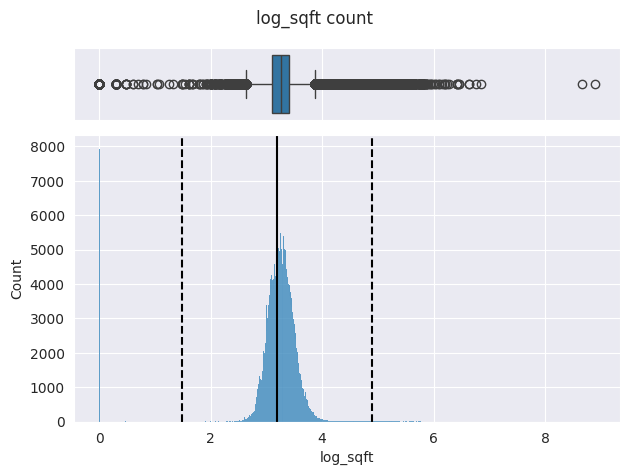

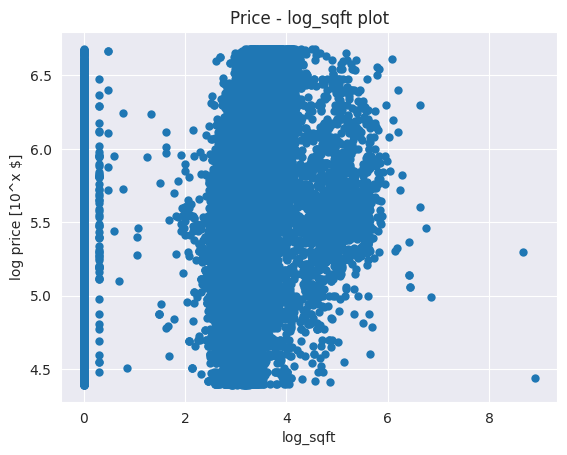

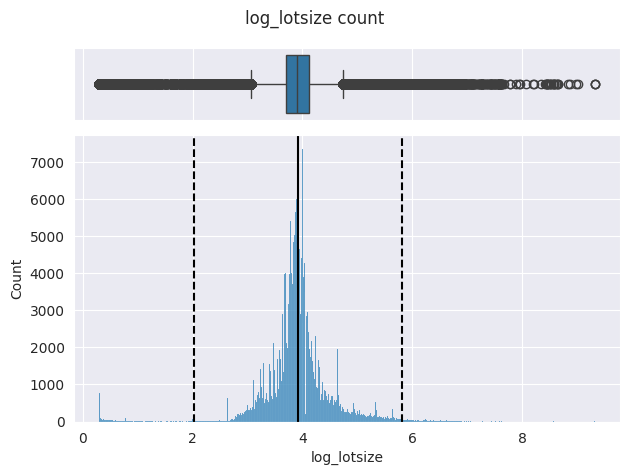

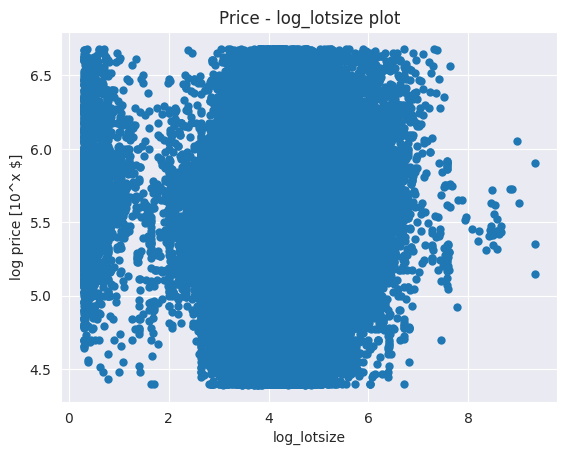

In [25]:
features = ('sqft', 'lotsize')

for feature in features:
    new_feature = 'log_' + feature
    print(new_feature)
    df[new_feature] = np.log10(df[feature]+1)
    p = feature_stats.test_normal(df[df[new_feature].notna()][new_feature])
    print()

log_features = ('log_sqft', 'log_lotsize')

df = df.drop(list(features), axis=1)

visualize.plot_numerical_stats(
    df,
    feature_names=log_features,
    target='log_target',
    numeric_label='log price [10^x $]',
    logx=False,
    logy=False,
    std_lines=True
)

Имеются выбросы, требующие обработки. Выявим их и заполним медианным значением.

log_sqft
ITERATION 1
Количество выбросов в log_sqft по методу z-отклонений: 19215
ITERATION 2
Количество выбросов в log_sqft по методу z-отклонений: 2013
ITERATION 3
Количество выбросов в log_sqft по методу z-отклонений: 704
ITERATION 4
Количество выбросов в log_sqft по методу z-отклонений: 111
ITERATION 5
Количество выбросов в log_sqft по методу z-отклонений: 27
ITERATION 6
Количество выбросов в log_sqft по методу z-отклонений: 5
ITERATION 7
Количество выбросов в log_sqft по методу z-отклонений: 0
Истинные выбросы (не NaNs): 11640

log_lotsize
ITERATION 1
Количество выбросов в log_lotsize по методу z-отклонений: 85047
ITERATION 2
Количество выбросов в log_lotsize по методу z-отклонений: 3832
ITERATION 3
Количество выбросов в log_lotsize по методу z-отклонений: 2541
ITERATION 4
Количество выбросов в log_lotsize по методу z-отклонений: 1662
ITERATION 5
Количество выбросов в log_lotsize по методу z-отклонений: 793
ITERATION 6
Количество выбросов в log_lotsize по методу z-отклонений: 293


count    330799.000000
mean          3.265251
std           0.217660
min           2.612784
25%           3.114277
50%           3.261501
75%           3.410102
max           3.918135
Name: log_sqft, dtype: float64

Доля объявлений с пропуском в log_sqft: 0.000%
log_lotsize


count    330799.000000
mean          3.893913
std           0.395462
min           2.708421
25%           3.699838
50%           3.886885
75%           4.086282
max           5.080002
Name: log_lotsize, dtype: float64

Доля объявлений с пропуском в log_lotsize: 0.000%


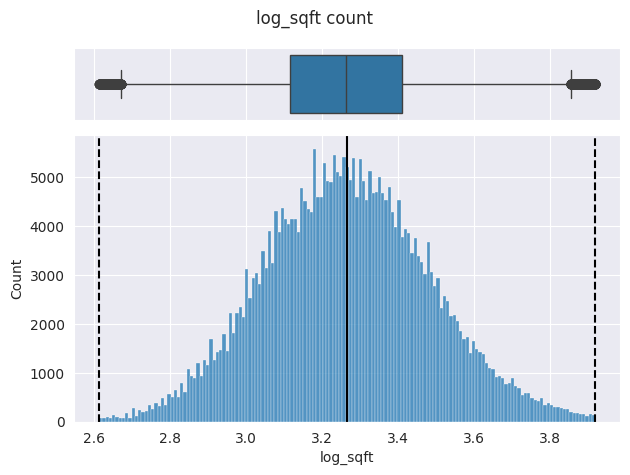

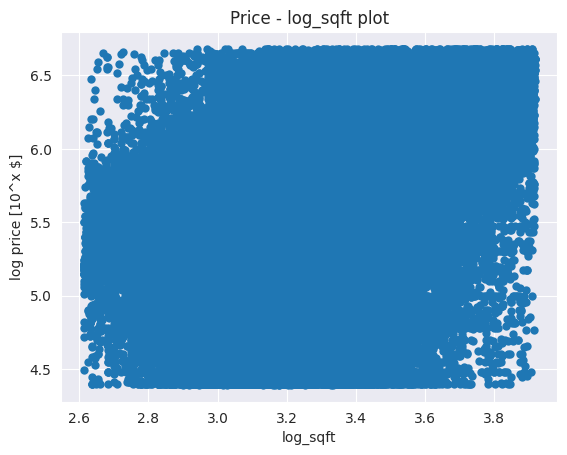

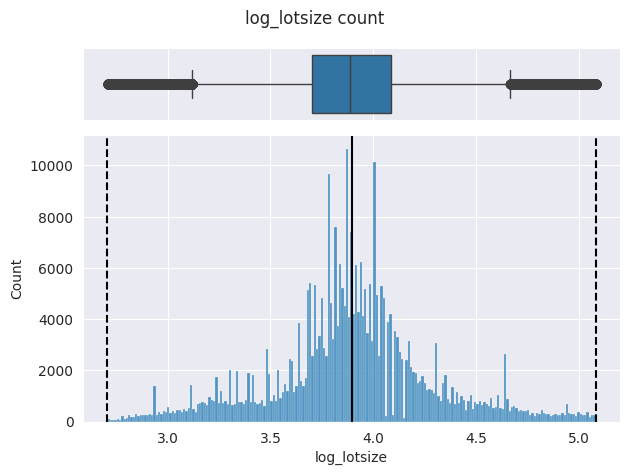

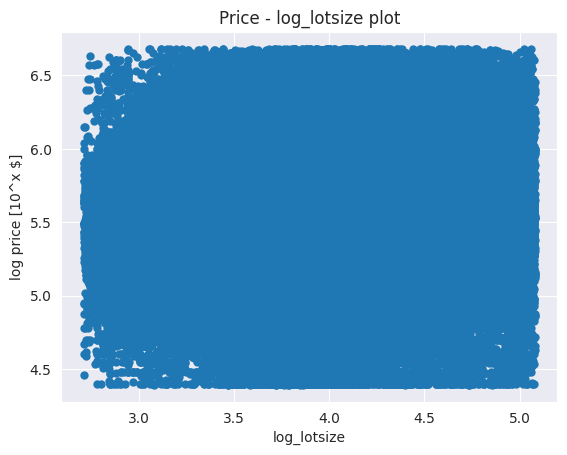

In [26]:
log_features = ('log_sqft', 'log_lotsize')

# outliers_idx = {}
for feature in log_features:
    print(feature)
    clean, outliers = feature_stats.get_df_no_outliers(
        data=df,
        feature=feature,
        method='z-score'
    )
    df.loc[outliers.index, feature] = np.nan
    # Fill forward to make less distribution disturbance
    df[feature] = df[feature].ffill()
    # Fill others
    df[feature] = df[feature].fillna(df[feature].median())
    
    true_outliers_cnt = outliers[outliers[feature].notna()].shape[0]
    print('Истинные выбросы (не NaNs):', true_outliers_cnt)
    print()

visualize.plot_numerical_stats(
    df,
    feature_names=log_features,
    target='log_target',
    numeric_label='log price [10^x $]',
    logx=False,
    logy=False,
    std_lines=True
)

## parking_type and parking_count

Исследование в data-understanding показало, что количество парковок больше 3 малочисленно.
Заполним пропуски нулём и 'street' соответственно, так как доля пропусков большая.
Положим, что на улице припарковаться можно

parking_type


parking_type
street    0.494575
garage    0.295732
other     0.209692
Name: proportion, dtype: float64

Доля объявлений с пропуском в parking_type: 0.000%


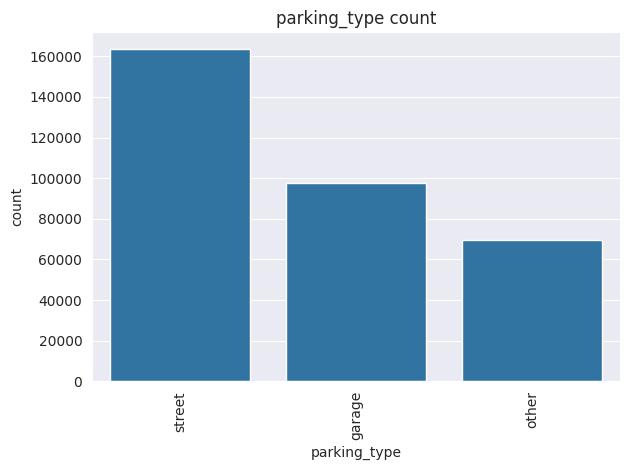

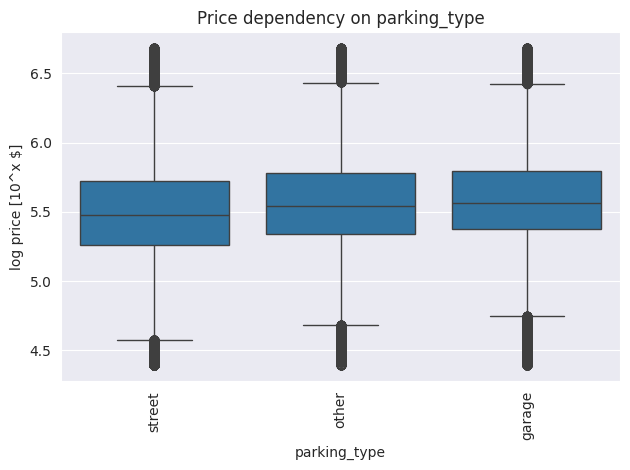

parking_count


parking_count
0.0    0.462580
1.0    0.401748
2.0    0.098885
3.0    0.036787
Name: proportion, dtype: float64

Доля объявлений с пропуском в parking_count: 0.000%


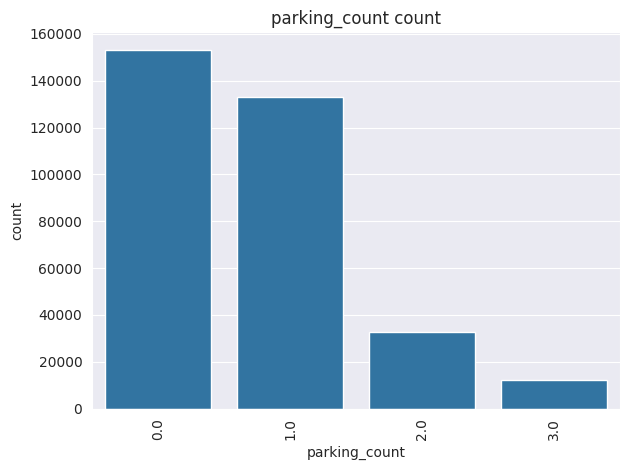

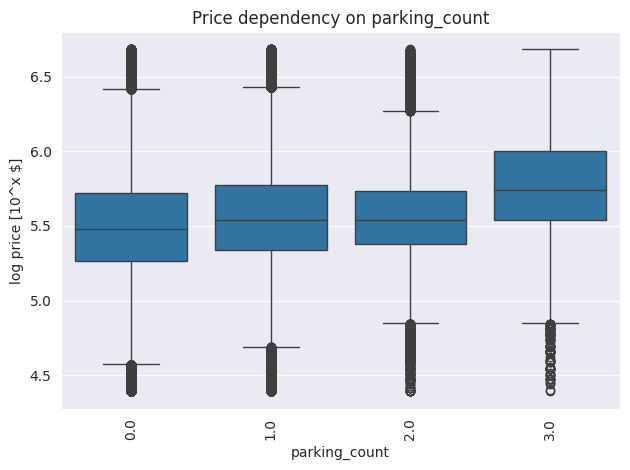

In [27]:
df['parking_count'] = df['parking_count'].clip(0, 3)
df['parking_count'] = df['parking_count'].fillna(0)

df['parking_type'] = build_features.get_categorical_feature(
    df['parking_type'],
    isin_dict={
        'street': ['on street', 'off street'],
        'other': ['other', 'carport']
    },
    first_launch=False
)
df['parking_type'] = df['parking_type'].fillna('street')

visualize.plot_categorical_stats(
    df,
    feature_names=('parking_type', 'parking_count'),
    target='log_target',
    numeric_label='log price [10^x $]',
)

## Heating and Cooling

- central_heating
- central_cooling

central_heating


central_heating
True     0.514409
False    0.485591
Name: proportion, dtype: float64

Доля объявлений с пропуском в central_heating: 0.000%


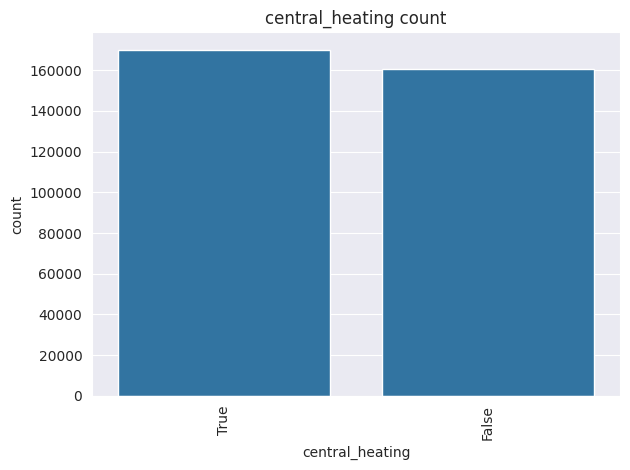

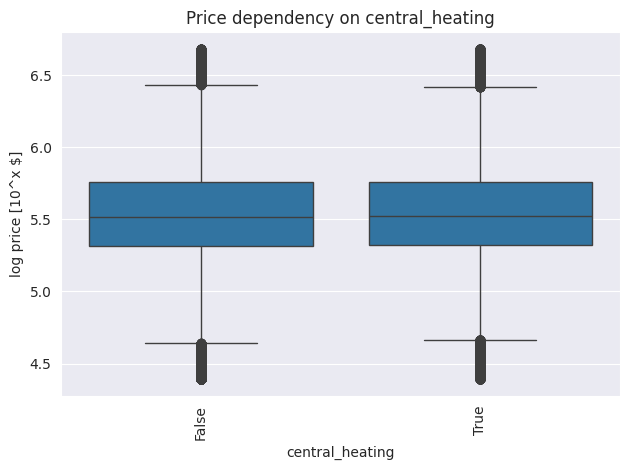

central_cooling


central_cooling
True     0.605102
False    0.394898
Name: proportion, dtype: float64

Доля объявлений с пропуском в central_cooling: 0.000%


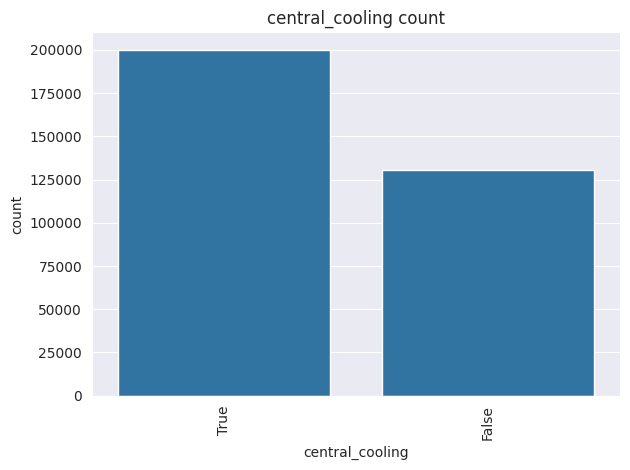

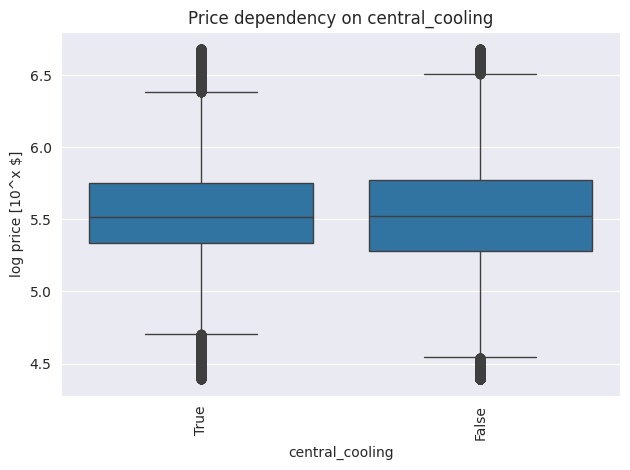

In [28]:
visualize.plot_categorical_stats(
    df,
    feature_names=('central_heating', 'central_cooling'),
    target='log_target',
    numeric_label='log price [10^x $]',
)

- heating_type
- cooling_type

heating_type


heating_type
central      0.594329
other        0.135265
electric     0.102140
gas          0.063904
pump         0.051873
wall         0.017709
baseboard    0.017178
furnace      0.010332
radiant      0.007270
Name: proportion, dtype: float64

Доля объявлений с пропуском в heating_type: 24.363%


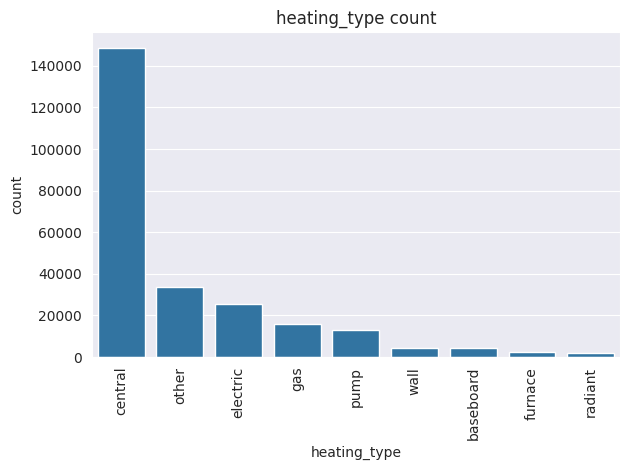

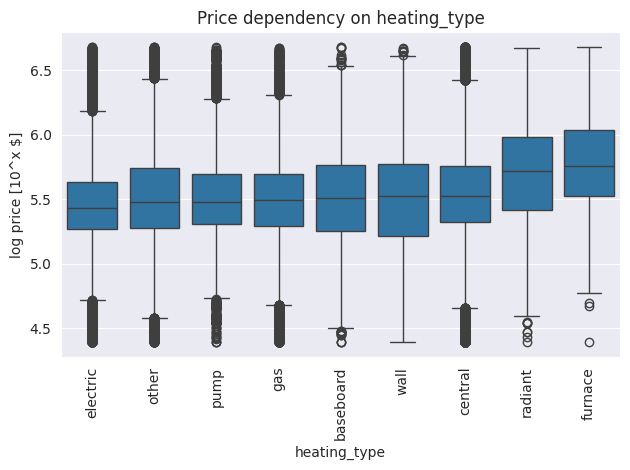

cooling_type


cooling_type
central          0.780817
other            0.109171
electric         0.061884
wall             0.024208
fan              0.011239
refrigeration    0.007352
evaporative      0.005330
Name: proportion, dtype: float64

Доля объявлений с пропуском в cooling_type: 28.534%


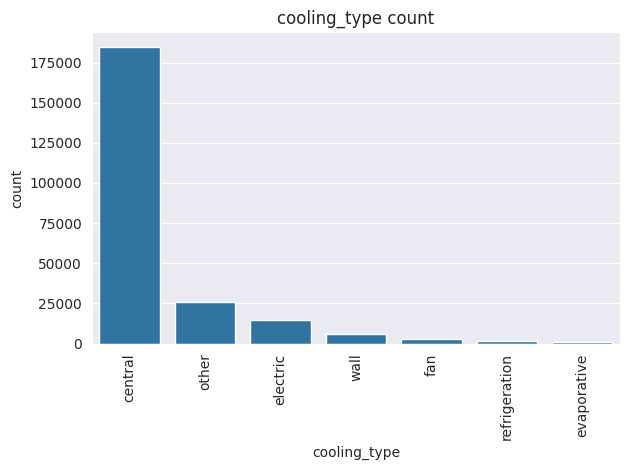

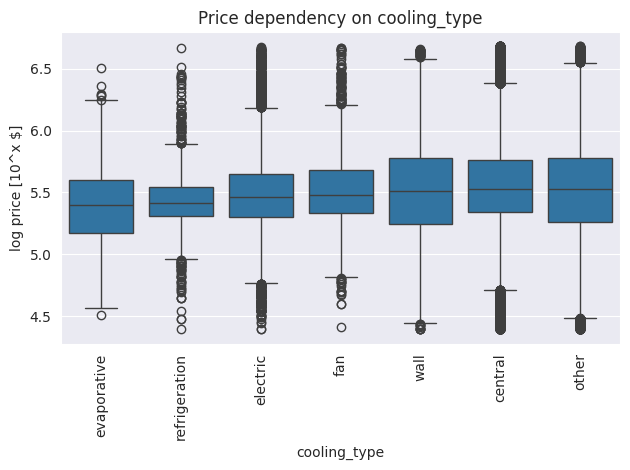

In [29]:
visualize.plot_categorical_stats(
    df,
    feature_names=('heating_type', 'cooling_type'),
    target='log_target',
    numeric_label='log price [10^x $]',
)

Объединим категории. 

Пропуски заполним в соответствии с property_type.

heating_type


heating_type
central     0.677315
other       0.142011
electric    0.093105
gas/pump    0.087570
Name: proportion, dtype: float64

Доля объявлений с пропуском в heating_type: 0.000%


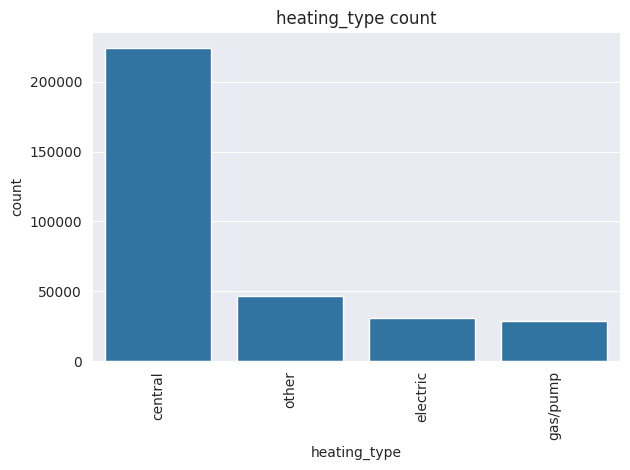

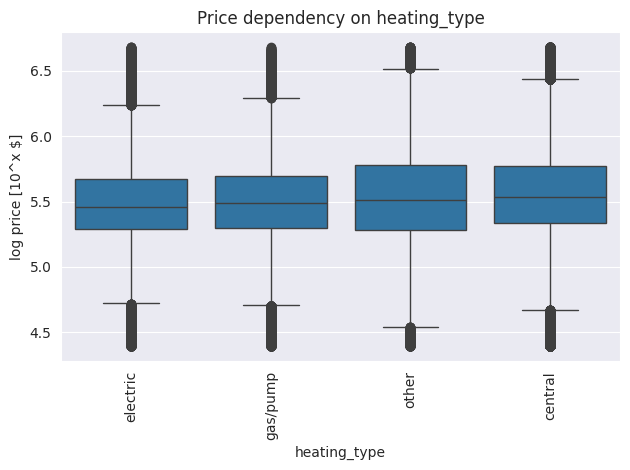

cooling_type


cooling_type
central              0.824265
other                0.114414
refrigeration/fan    0.061321
Name: proportion, dtype: float64

Доля объявлений с пропуском в cooling_type: 0.000%


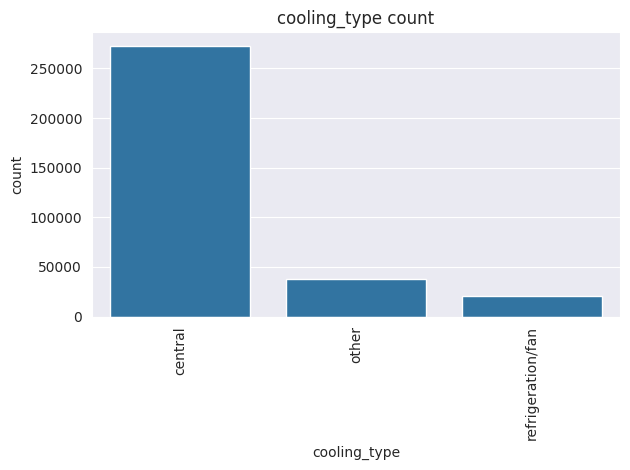

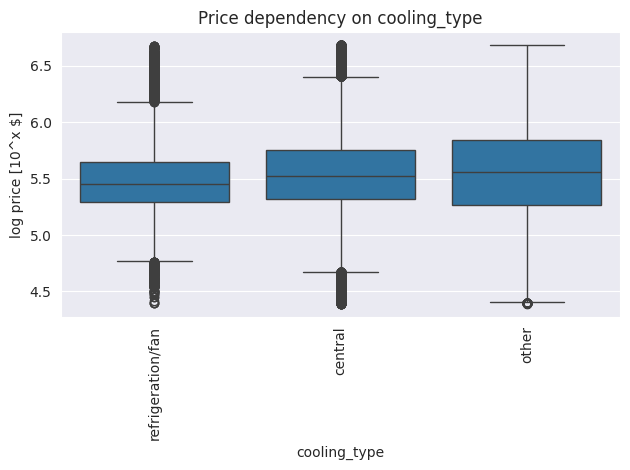

In [30]:
df['heating_type'] = build_features.get_categorical_feature(
    df['heating_type'],
    isin_dict={
        'other': ['other', 'furnace', 'radiant', 'wall', 'baseboard'],
        'gas/pump': ['gas', 'pump'],
    },
    first_launch=False
)

df['cooling_type'] = build_features.get_categorical_feature(
    df['cooling_type'],
    isin_dict={
        'other': ['other', 'wall'],
        'refrigeration/fan': [
            'electric', 'refrigeration', 'evaporative', 'fan'
        ],
    },
    first_launch=False
)

df = feature_stats.fillna_by_reference(
    df,
    reference='property_type',
    features=('cooling_type', 'heating_type')
)

visualize.plot_categorical_stats(
    df,
    feature_names=('heating_type', 'cooling_type'),
    target='log_target',
    numeric_label='log price [10^x $]',
)

# Проектирование признаков

## Year

- remodeled_year
- year_built

Создадим признак, определяющий количество лет после последнего ремоделирования
или постройки. При этом удалим признак "remodeled_year"

Последний упоминаемый год: 2022.0
updated_years


count    301305.000000
mean         37.584152
std          31.021798
min           0.000000
25%          14.000000
50%          31.000000
75%          56.000000
max         322.000000
Name: updated_years, dtype: float64

Доля объявлений с пропуском в updated_years: 8.916%


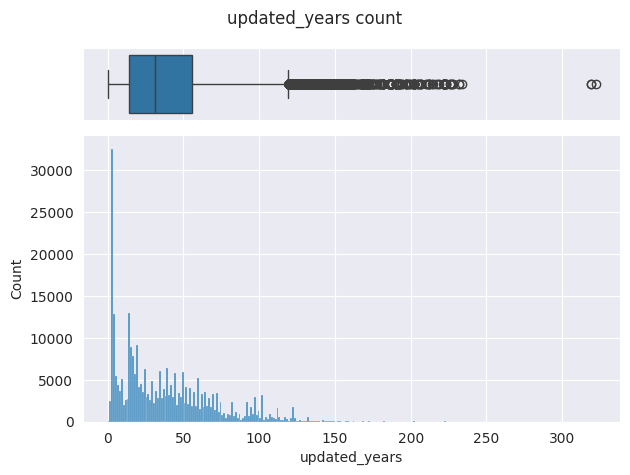

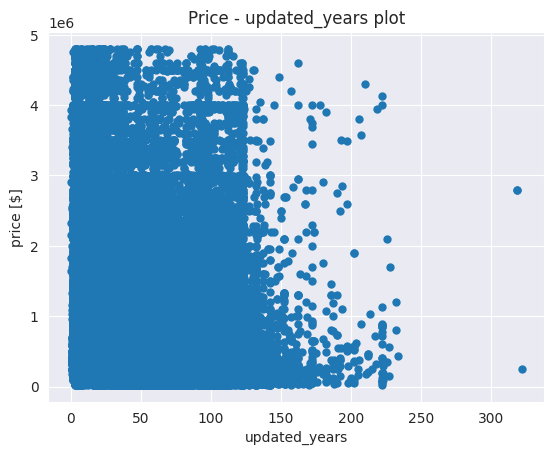

In [31]:
df = build_features.get_df_updated_years(df)
visualize.plot_numerical_stats(
    df, 
    ('updated_years',),
    logx=False,
    logy=False,
)

updated_years
ITERATION 1
Количество выбросов в updated_years по методу Тьюки: 34348
ITERATION 2
Количество выбросов в updated_years по методу Тьюки: 1230
ITERATION 3
Количество выбросов в updated_years по методу Тьюки: 0
Истинные выбросы (не NaNs): 6084
updated_years


count    330799.000000
mean         37.317129
std          30.179212
min           0.000000
25%          14.000000
50%          31.000000
75%          56.000000
max         114.000000
Name: updated_years, dtype: float64

Доля объявлений с пропуском в updated_years: 0.000%


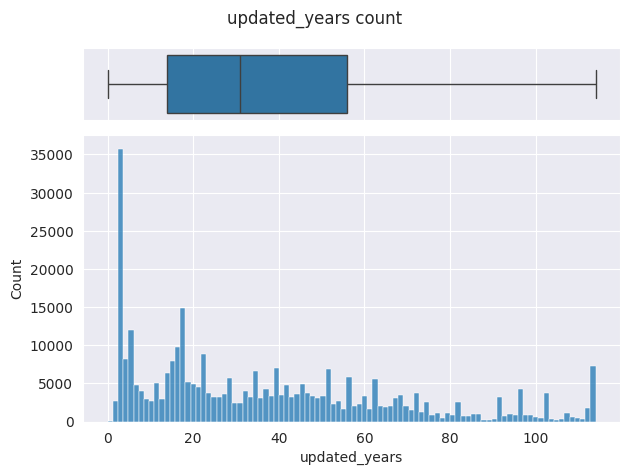

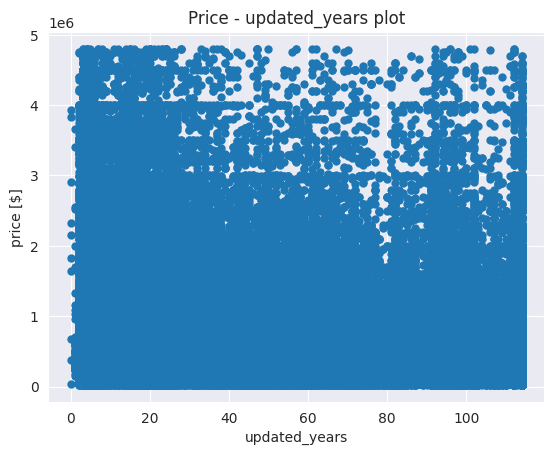

In [32]:
features = ('updated_years',)
df = feature_stats.fill_outliers(df, features=features, method='iqr')

# Fill forward to make less distribution disturbance
feature = features[0]
df[feature] = df[feature].ffill()

# Drop original columns
df = df.drop(['year_built'], axis=1)

visualize.plot_numerical_stats(
    df, 
    (feature,),
    logx=False,
    logy=False,
)

Если отслеживать по плотности точек, то видим обратную корреляцию цены со временем после последнего обновления

Удалим признаки:
- school_grades
- school_name

Впоследствии их тоже можно было бы обработать (см. data-understanding)

In [33]:
df = df.drop(['school_grades', 'school_name'], axis=1)

Займёмся проектированием признаков на основе:
- school_rating - Done
- school_distance - Done

## School_rating and school_distance

Извлечём количество школ
минимальное и медианное расстояние до школ

Максимальный и медианный рейтинг

In [34]:
df['school_count'] = df['school_distance'].apply(len)
df['school_distance'] = build_features.get_numerical_distance(
    df['school_distance']
)
df['min_log_school_distance'] = (
    np.log10(df['school_distance'].apply(np.min) + 1e-3)
)
df['median_log_school_distance'] = (
    np.log10(df['school_distance'].apply(np.median) + 1e-3)
)

df['school_rating'] = build_features.get_numerical_rating(df['school_rating'])
df['max_school_rating'] = df['school_rating'].apply(np.max)
df['median_school_rating'] = df['school_rating'].apply(np.median)

df = df.drop(['school_distance', 'school_rating'], axis=1)

school_count


school_count
3     0.561178
8     0.113697
2     0.099299
5     0.072533
4     0.055708
6     0.028120
1     0.022255
7     0.015916
0     0.009686
24    0.005348
10    0.002161
63    0.002059
11    0.001998
13    0.001941
9     0.001394
12    0.001267
22    0.001248
65    0.001034
14    0.000937
49    0.000722
15    0.000623
61    0.000330
16    0.000308
21    0.000224
26    0.000009
17    0.000006
Name: proportion, dtype: float64

Доля объявлений с пропуском в school_count: 0.000%


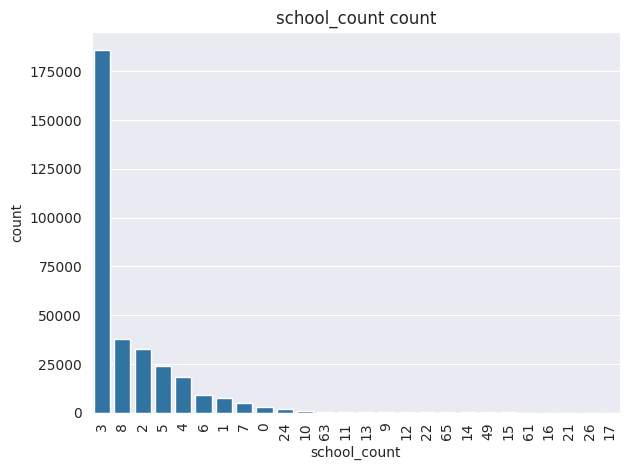

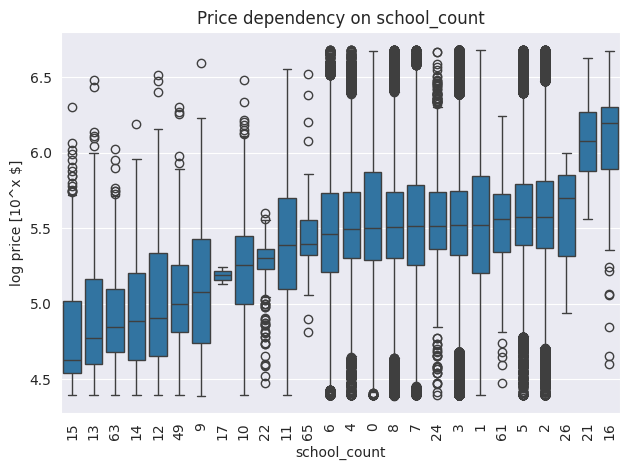

min_log_school_distance


count    327595.000000
mean         -0.172590
std           0.424954
min          -3.000000
25%          -0.442493
50%          -0.179799
75%           0.097257
max           3.201501
Name: min_log_school_distance, dtype: float64

Доля объявлений с пропуском в min_log_school_distance: 0.969%
median_log_school_distance


count    327595.000000
mean          0.197119
std           0.372371
min          -3.000000
25%          -0.045275
50%           0.179264
75%           0.426674
max           3.201676
Name: median_log_school_distance, dtype: float64

Доля объявлений с пропуском в median_log_school_distance: 0.969%
max_school_rating


count    247615.000000
mean          6.501024
std           2.275953
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: max_school_rating, dtype: float64

Доля объявлений с пропуском в max_school_rating: 25.146%
median_school_rating


count    247615.000000
mean          5.043160
std           2.089559
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          10.000000
Name: median_school_rating, dtype: float64

Доля объявлений с пропуском в median_school_rating: 25.146%


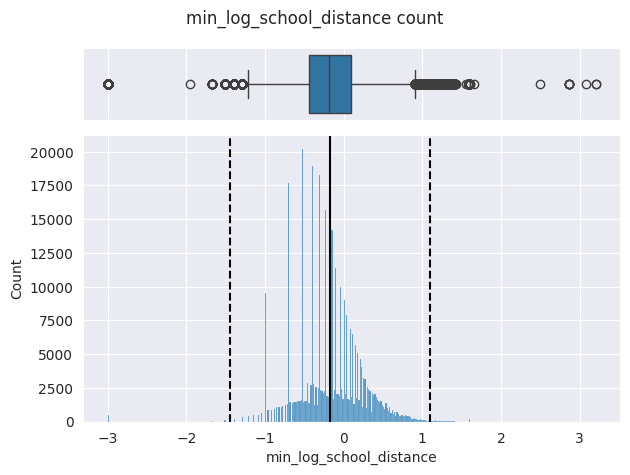

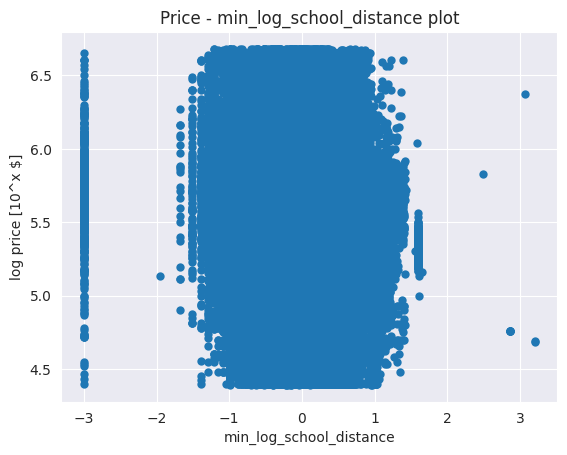

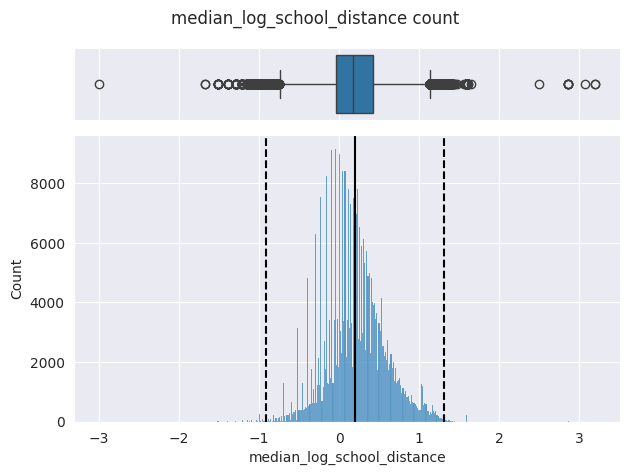

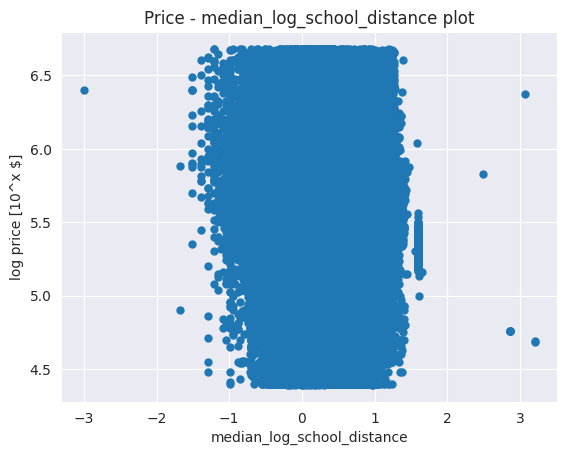

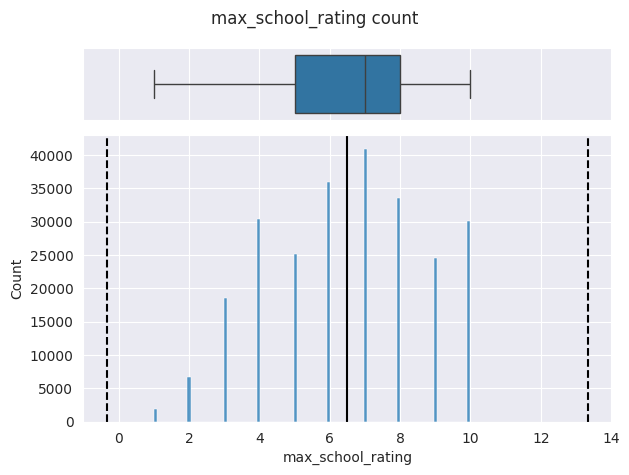

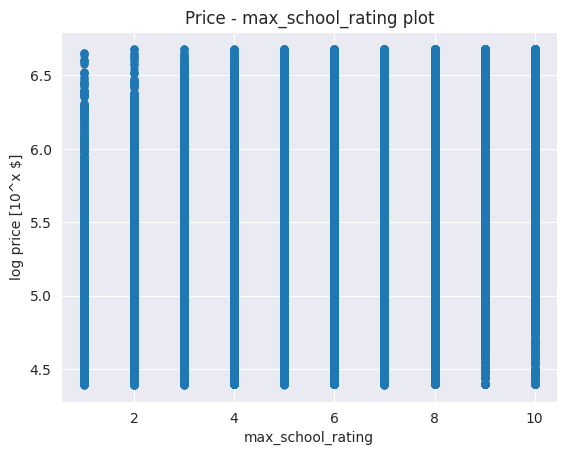

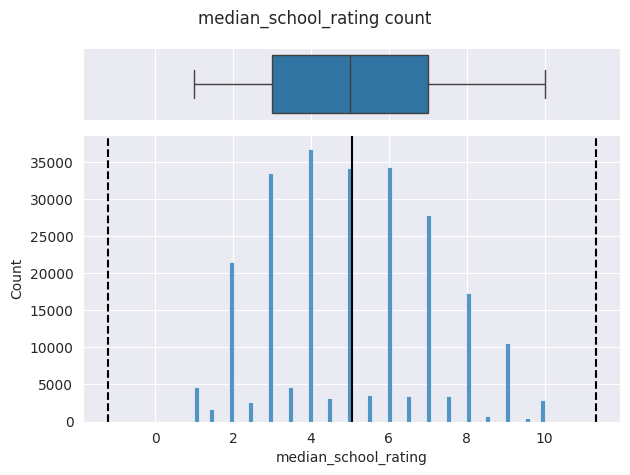

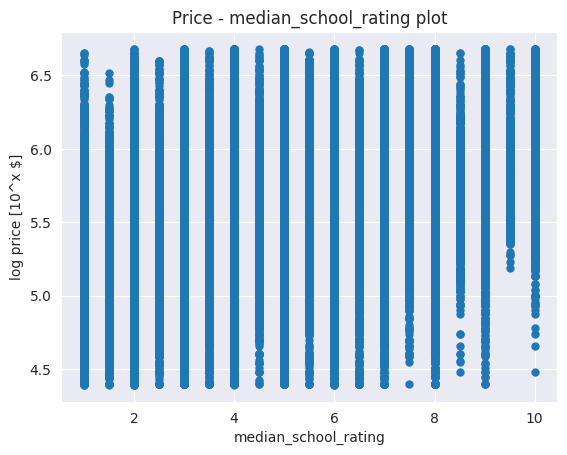

In [35]:
visualize.plot_categorical_stats(
    df,
    feature_names=(
        'school_count',
    ),
    target='log_target',
    numeric_label='log price [10^x $]',
)

visualize.plot_numerical_stats(
    df,
    feature_names=(
        'min_log_school_distance', 'median_log_school_distance', 
        'max_school_rating', 'median_school_rating'
    ),
    target='log_target',
    numeric_label='log price [10^x $]',
    logy=False,
    logx=False,
    std_lines=True
)

Очистим эти датасеты

min_log_school_distance
ITERATION 1
Количество выбросов в min_log_school_distance по методу z-отклонений: 4855
ITERATION 2
Количество выбросов в min_log_school_distance по методу z-отклонений: 453
ITERATION 3
Количество выбросов в min_log_school_distance по методу z-отклонений: 58
ITERATION 4
Количество выбросов в min_log_school_distance по методу z-отклонений: 2
ITERATION 5
Количество выбросов в min_log_school_distance по методу z-отклонений: 0
Истинные выбросы (не NaNs): 2164
median_log_school_distance
ITERATION 1
Количество выбросов в median_log_school_distance по методу z-отклонений: 4349
ITERATION 2
Количество выбросов в median_log_school_distance по методу z-отклонений: 175
ITERATION 3
Количество выбросов в median_log_school_distance по методу z-отклонений: 15
ITERATION 4
Количество выбросов в median_log_school_distance по методу z-отклонений: 6
ITERATION 5
Количество выбросов в median_log_school_distance по методу z-отклонений: 0
Истинные выбросы (не NaNs): 1341
min_log_school_d

count    330799.000000
mean         -0.171027
std           0.409739
min          -1.292430
25%          -0.442493
50%          -0.179799
75%           0.097257
max           1.025347
Name: min_log_school_distance, dtype: float64

Доля объявлений с пропуском в min_log_school_distance: 0.000%


median_log_school_distance


count    330799.000000
mean          0.197236
std           0.370060
min          -0.882729
25%          -0.045275
50%           0.179264
75%           0.426674
max           1.289165
Name: median_log_school_distance, dtype: float64

Доля объявлений с пропуском в median_log_school_distance: 0.000%
max_school_rating


count    330799.000000
mean          6.501972
std           2.275128
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: max_school_rating, dtype: float64

Доля объявлений с пропуском в max_school_rating: 0.000%
median_school_rating


count    330799.000000
mean          5.043712
std           2.089347
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          10.000000
Name: median_school_rating, dtype: float64

Доля объявлений с пропуском в median_school_rating: 0.000%


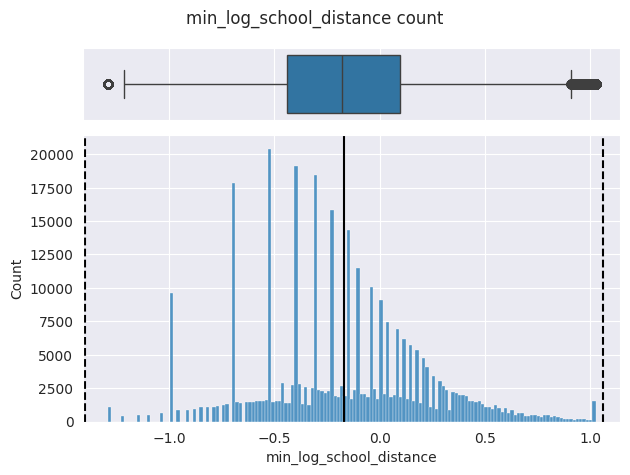

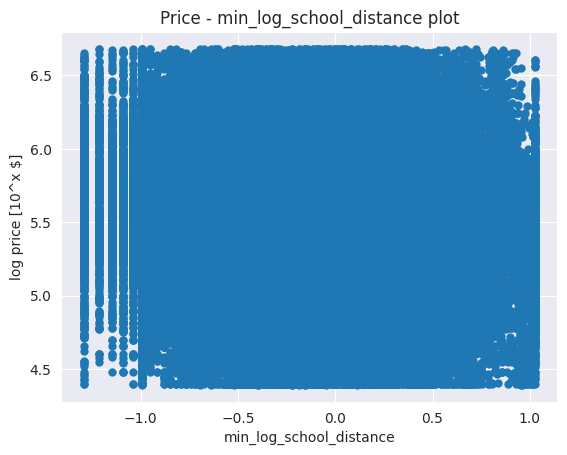

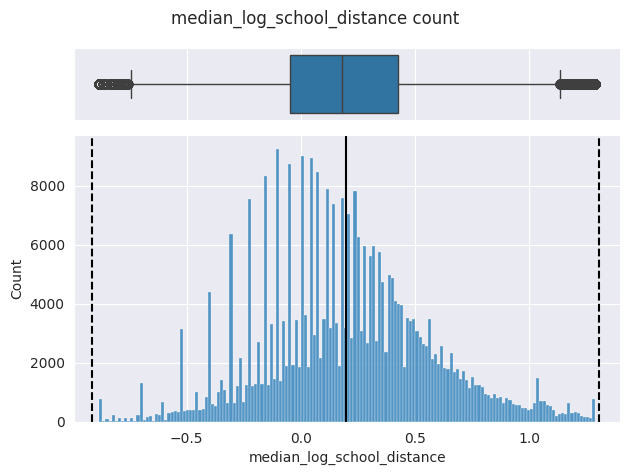

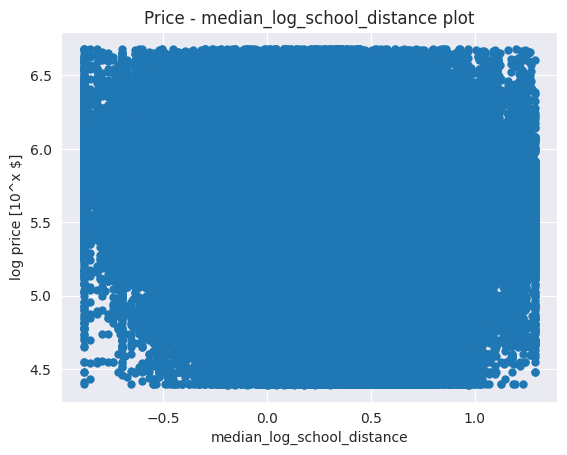

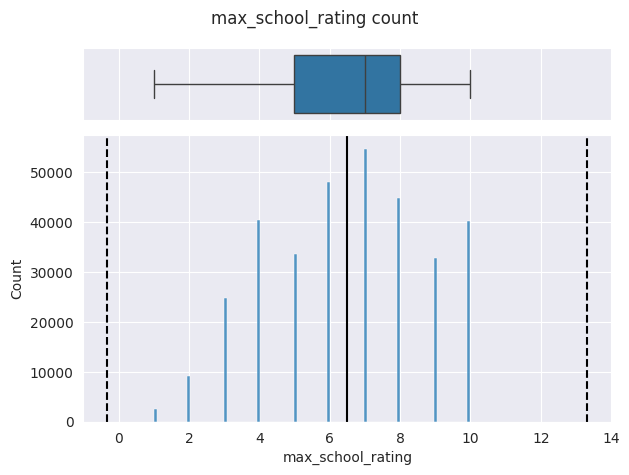

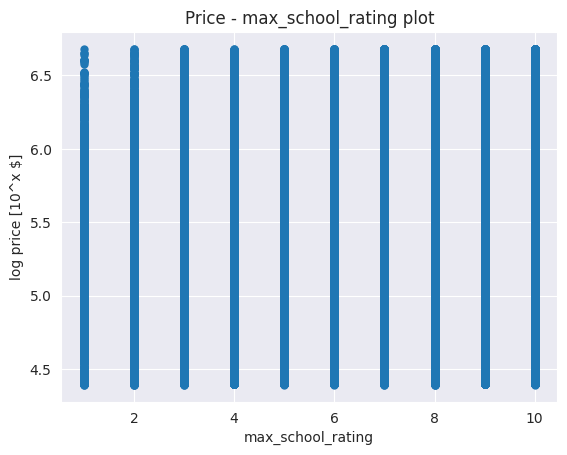

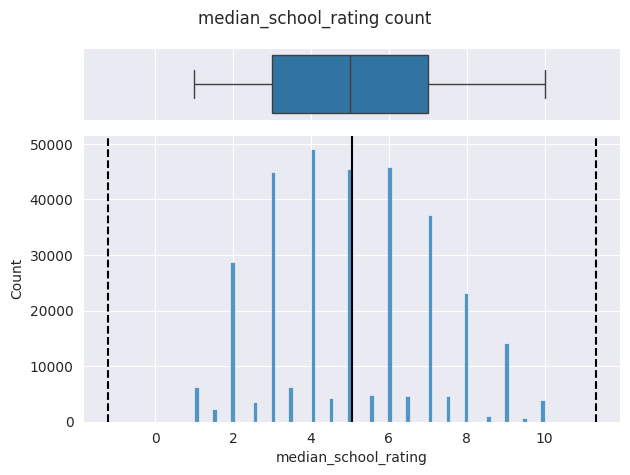

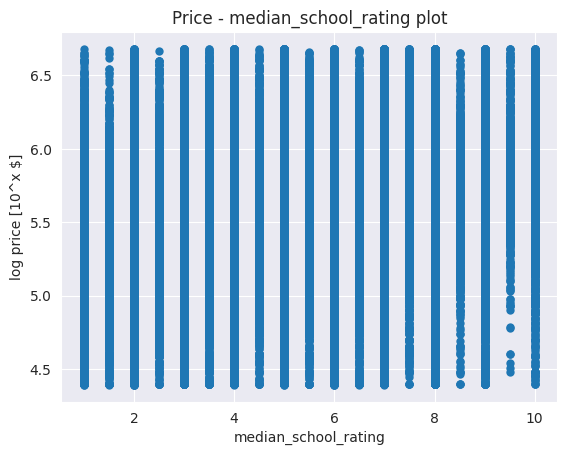

In [36]:
df['school_count'] = df['school_count'].clip(1, 8)

features = ('min_log_school_distance', 'median_log_school_distance')

df = feature_stats.fill_outliers(df, features=features)

# Fill NaNs
features = (
    'min_log_school_distance', 'median_log_school_distance',
    'max_school_rating', 'median_school_rating'
)
for feature in features:
    df[feature] = df[feature].ffill()
    df[feature] = df[feature].fillna(df[feature].median())

visualize.plot_numerical_stats(
    df,
    feature_names=features,
    target='log_target',
    numeric_label='log price [10^x $]',
    logy=False,
    logx=False,
    std_lines=True
)

Доля пропусков по колонкам:


status                        0.0
heating_type                  0.0
max_school_rating             0.0
median_log_school_distance    0.0
min_log_school_distance       0.0
school_count                  0.0
updated_years                 0.0
log_lotsize                   0.0
log_sqft                      0.0
log_target                    0.0
cooling_type                  0.0
central_cooling               0.0
central_heating               0.0
baths                         0.0
parking_count                 0.0
parking_type                  0.0
property_type                 0.0
mls                           0.0
private_pool                  0.0
target                        0.0
stories                       0.0
state                         0.0
beds                          0.0
fireplace                     0.0
median_school_rating          0.0
dtype: float64

Нормир. распределение количества пропусков по строкам


row_nans
0    1.0
Name: proportion, dtype: float64

(<Figure size 800x1200 with 3 Axes>,
 Index(['status', 'heating_type', 'max_school_rating',
        'median_log_school_distance', 'min_log_school_distance', 'school_count',
        'updated_years', 'log_lotsize', 'log_sqft', 'log_target',
        'cooling_type', 'central_cooling', 'central_heating', 'baths',
        'parking_count', 'parking_type', 'property_type', 'mls', 'private_pool',
        'target', 'stories', 'state', 'beds', 'fireplace',
        'median_school_rating'],
       dtype='object'))

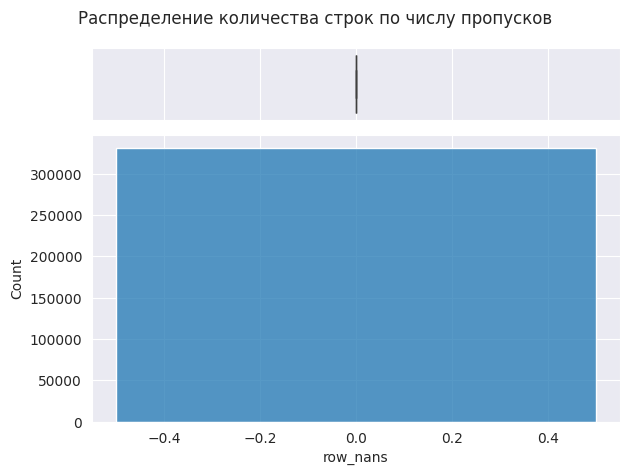

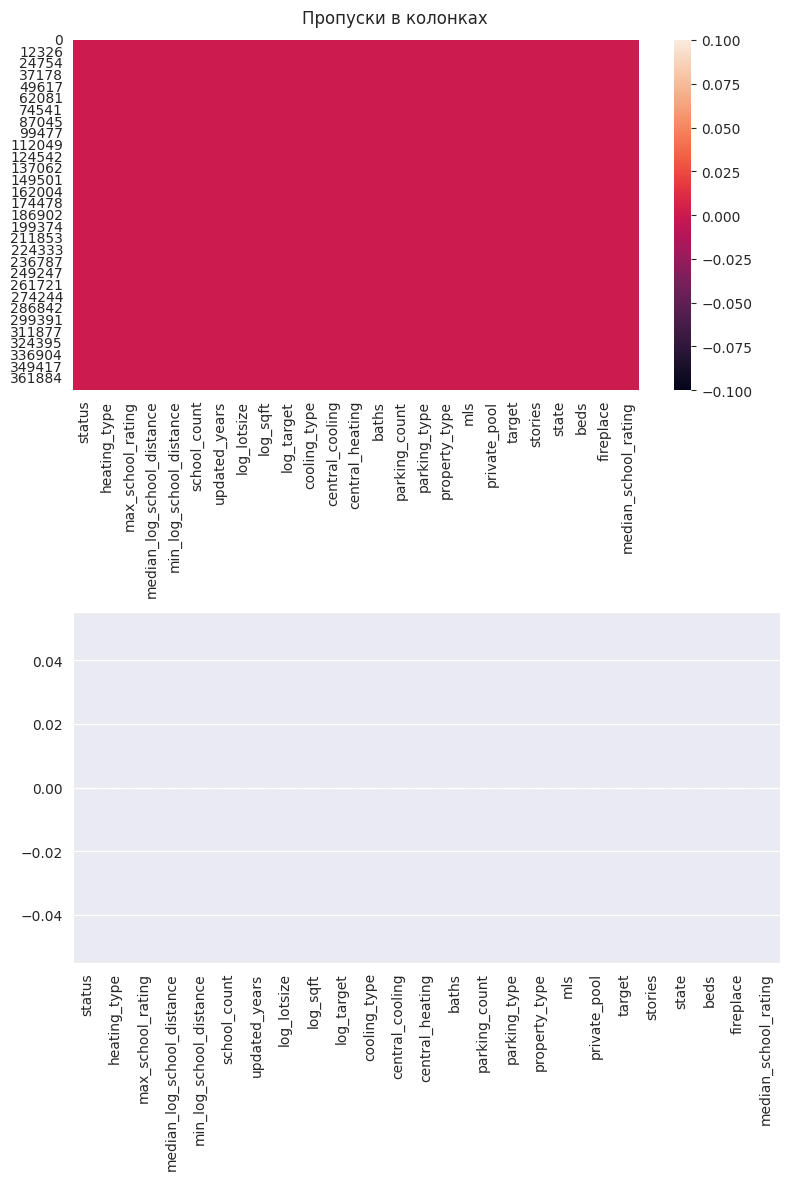

In [37]:
visualize.plot_nans_stat(df, check_nans=df.columns)

# Export

Подготовим датасет для моделирования

In [38]:
df.info()
df.head()
df.to_csv(preprocessed_data)

<class 'pandas.core.frame.DataFrame'>
Index: 330799 entries, 0 to 374305
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status                      330799 non-null  object 
 1   baths                       330799 non-null  float64
 2   fireplace                   330799 non-null  bool   
 3   beds                        330799 non-null  float64
 4   state                       330799 non-null  object 
 5   stories                     330799 non-null  float64
 6   target                      330799 non-null  int64  
 7   private_pool                330799 non-null  bool   
 8   mls                         330799 non-null  bool   
 9   property_type               330799 non-null  object 
 10  parking_type                330799 non-null  object 
 11  parking_count               330799 non-null  float64
 12  central_heating             330799 non-null  bool   
 13  heating_type       

Функция подготовки `make_preprocessed_dataset` представлена в src/data/make_dataset.py